# <center> Forecasting Criminal Activity in San Francisco <center> 

# Introduction

This notebook focuses on the use of historical crime data in San Francisco to predict the probability of different categories of crime in a given neighborhood and date. The dataset was obtained from data.sfgov.org website, and multiple open data sources and crime incident data between 2003-2018 from the San Frasisco Police Department were used.

## Imports
We start by importing libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import calendar
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore")
from scipy.stats import randint as sp_randint
from matplotlib import cm
from math import log10
import geopandas as gpd
import geoplot as gplt
from datetime import timedelta, datetime
import plotly.express as px
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode (connected=True)
import cufflinks as cf
cf.go_offline()
pio.renderers.default='notebook'
from IPython.display import Image
from pyecharts.charts import Pie
from pyecharts import options as opts
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import xgboost as xgb

## Data Loading  and Exploratory Data Analysis

### Census Tracts 
The census tract is an area roughly equivalent to a neighborhood established by the Bureau of Census for analyzing populations. Here we load Census Tracts data as gdf_tract geodataframe.

In [2]:
gdf_tract = gpd.read_file('geo_export_cb4da69b-a53a-45a0-aa3a-4976974962d2.dbf')
gdf_tract.crs = {'init': 'epsg:4326', 'no_defs': True} 

type(gdf_tract)
type(gdf_tract['tractce10'].iloc[0])

gdf_tract['tractce10']=gdf_tract['tractce10'].apply(lambda x: float(x[1:])/100)
gdf_tract = gdf_tract.rename(columns={'tractce10':'tract', 'nhood':'neighborhood'})
gdf_tract.head(2)

geoid      neighborhood    shape_area    shape_len  tract  \
0  06075016400      Hayes Valley  3.326589e+06  7589.679396  164.0   
1  06075016100  Western Addition  3.970259e+06  8525.808755  161.0   

                                            geometry  
0  POLYGON ((-122.43247 37.77376, -122.43411 37.7...  
1  POLYGON ((-122.42354 37.77967, -122.42345 37.7...

### Neighborhoods 
Each neighborhood includes several census tracts that are grouped together based on their demographic characteristics. Here we load Neighborhoods data as gdf_nbhd geodataframe.

In [3]:
gdf_nbhd = gpd.read_file('geo_export_08432dc0-b4e4-4b62-8a75-f5512aeed55b.dbf')
gdf_nbhd.crs = {'init': 'epsg:4326', 'no_defs': True}
gdf_nbhd = gdf_nbhd.rename(columns={'nhood':'neighborhood'})
gdf_nbhd.head(2)

neighborhood                                           geometry
0  Bayview Hunters Point  POLYGON ((-122.38158 37.75307, -122.38157 37.7...
1         Bernal Heights  POLYGON ((-122.40361 37.74934, -122.40378 37.7...

### Crime 
We load Police Department Incident Reports on 39 different crime categories as df_crime. 

In [4]:
df_crime=pd.read_csv('Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
df_crime.columns=df_crime.columns.str.lower().str.replace(" ", "_")
df_crime.head(2)

incidntnum      category               descript dayofweek        date  \
0   150060275  NON-CRIMINAL          LOST PROPERTY    Monday  01/19/2015   
1   150098210       ROBBERY  ROBBERY, BODILY FORCE    Sunday  02/01/2015   

    time  pddistrict resolution                      address           x  \
0  14:00     MISSION       NONE        18TH ST / VALENCIA ST -122.421582   
1  15:45  TENDERLOIN       NONE  300 Block of LEAVENWORTH ST -122.414406   

           y                               location            pdid  
0  37.761701   (37.7617007179518, -122.42158168137)  15006027571000  
1  37.784191  (37.7841907151119, -122.414406029855)  15009821003074

To perform spatial joins visualize geographical columns, we convert Crime dataframe to geodatafram.

In [5]:
#X=longitude, y=Latitude
gdf_crime = gpd.GeoDataFrame(
    df_crime, geometry=gpd.points_from_xy(df_crime['x'], df_crime['y']))
gdf_crime.crs = {'init': 'epsg:4326', 'no_defs': True}

gdf_crime.head(2)

incidntnum      category               descript dayofweek        date  \
0   150060275  NON-CRIMINAL          LOST PROPERTY    Monday  01/19/2015   
1   150098210       ROBBERY  ROBBERY, BODILY FORCE    Sunday  02/01/2015   

    time  pddistrict resolution                      address           x  \
0  14:00     MISSION       NONE        18TH ST / VALENCIA ST -122.421582   
1  15:45  TENDERLOIN       NONE  300 Block of LEAVENWORTH ST -122.414406   

           y                               location            pdid  \
0  37.761701   (37.7617007179518, -122.42158168137)  15006027571000   
1  37.784191  (37.7841907151119, -122.414406029855)  15009821003074   

                      geometry  
0  POINT (-122.42158 37.76170)  
1  POINT (-122.41441 37.78419)

Now we join Neighborhood geodataframe to Crime geodataframe. Then convert the joined geodataframe to pandas dataframe and reset the index.

In [6]:
# Joining Neighborhood geodataframe to Crime geodataframe
gdf_joined_crime_nbhd = gpd.sjoin(gdf_crime, gdf_nbhd, how="inner", op='intersects')

# Converting the spatial joint geodataframe to pandas dataframe
df_joined_crime_nbhd = pd.DataFrame(gdf_joined_crime_nbhd)

# Resetting the index in dataframe 
df_joined_crime_nbhd=df_joined_crime_nbhd.reset_index(drop=True)
df_joined_crime_nbhd.head(2)

incidntnum       category                 descript dayofweek        date  \
0   150060275   NON-CRIMINAL            LOST PROPERTY    Monday  01/19/2015   
1   150098345  LARCENY/THEFT  PETTY THEFT SHOPLIFTING    Sunday  02/01/2015   

    time pddistrict      resolution                    address           x  \
0  14:00    MISSION            NONE      18TH ST / VALENCIA ST -122.421582   
1  14:00    MISSION  ARREST, BOOKED  1700 Block of HARRISON ST -122.413354   

           y                               location            pdid  \
0  37.761701   (37.7617007179518, -122.42158168137)  15006027571000   
1  37.769075  (37.7690748003847, -122.413354187018)  15009834506362   

                      geometry  index_right neighborhood  
0  POINT (-122.42158 37.76170)           20      Mission  
1  POINT (-122.41335 37.76907)           20      Mission

In [7]:
df_joined_crime_nbhd.shape

(2213986, 16)

We convert the date column to datetime format, and add year and month abbreviation columns to df_joined_crime_nbhd.

In [8]:
# Time formatting
df_joined_crime_nbhd['date']=pd.to_datetime(df_joined_crime_nbhd['date'])
df_joined_crime_nbhd['year']=df_joined_crime_nbhd['date'].apply(lambda x: x.year)
df_joined_crime_nbhd['month']=df_joined_crime_nbhd['date'].apply(lambda x:x.month)
df_joined_crime_nbhd['month']=df_joined_crime_nbhd['month'].apply(lambda x:calendar.month_abbr[x])
df_joined_crime_nbhd.head(2)

incidntnum       category                 descript dayofweek       date  \
0   150060275   NON-CRIMINAL            LOST PROPERTY    Monday 2015-01-19   
1   150098345  LARCENY/THEFT  PETTY THEFT SHOPLIFTING    Sunday 2015-02-01   

    time pddistrict      resolution                    address           x  \
0  14:00    MISSION            NONE      18TH ST / VALENCIA ST -122.421582   
1  14:00    MISSION  ARREST, BOOKED  1700 Block of HARRISON ST -122.413354   

           y                               location            pdid  \
0  37.761701   (37.7617007179518, -122.42158168137)  15006027571000   
1  37.769075  (37.7690748003847, -122.413354187018)  15009834506362   

                      geometry  index_right neighborhood  year month  
0  POINT (-122.42158 37.76170)           20      Mission  2015   Jan  
1  POINT (-122.41335 37.76907)           20      Mission  2015   Feb

We check whether df_joined_crime_nbhd needs data cleaning.

In [9]:
df_joined_crime_nbhd.isnull().sum()

incidntnum      0
category        0
descript        0
dayofweek       0
date            0
time            0
pddistrict      0
resolution      0
address         0
x               0
y               0
location        0
pdid            0
geometry        0
index_right     0
neighborhood    0
year            0
month           0
dtype: int64

In [10]:
df_joined_crime_nbhd.dtypes

incidntnum               int64
category                object
descript                object
dayofweek               object
date            datetime64[ns]
time                    object
pddistrict              object
resolution              object
address                 object
x                      float64
y                      float64
location                object
pdid                     int64
geometry              geometry
index_right              int64
neighborhood            object
year                     int64
month                   object
dtype: object

In order to visualize Neighborhoods and Census Tracts Maps, we converting df_joined_crime_nbhd dataframe to geodataframe.

In [11]:
# Converting df_joined_crime_nbhd dataframe to geodataframe
gdf_joined_crime_nbhd=gpd.GeoDataFrame(
    df_joined_crime_nbhd, geometry=gpd.points_from_xy(df_joined_crime_nbhd['x'], df_joined_crime_nbhd['y']))
gdf_joined_crime_nbhd.crs = {'init': 'epsg:4326', 'no_defs': True}

### Neighborhoods and Census Tracts Maps

Now we visualize the geometry of neighborhoods and census tracts, and add neighborhood names.

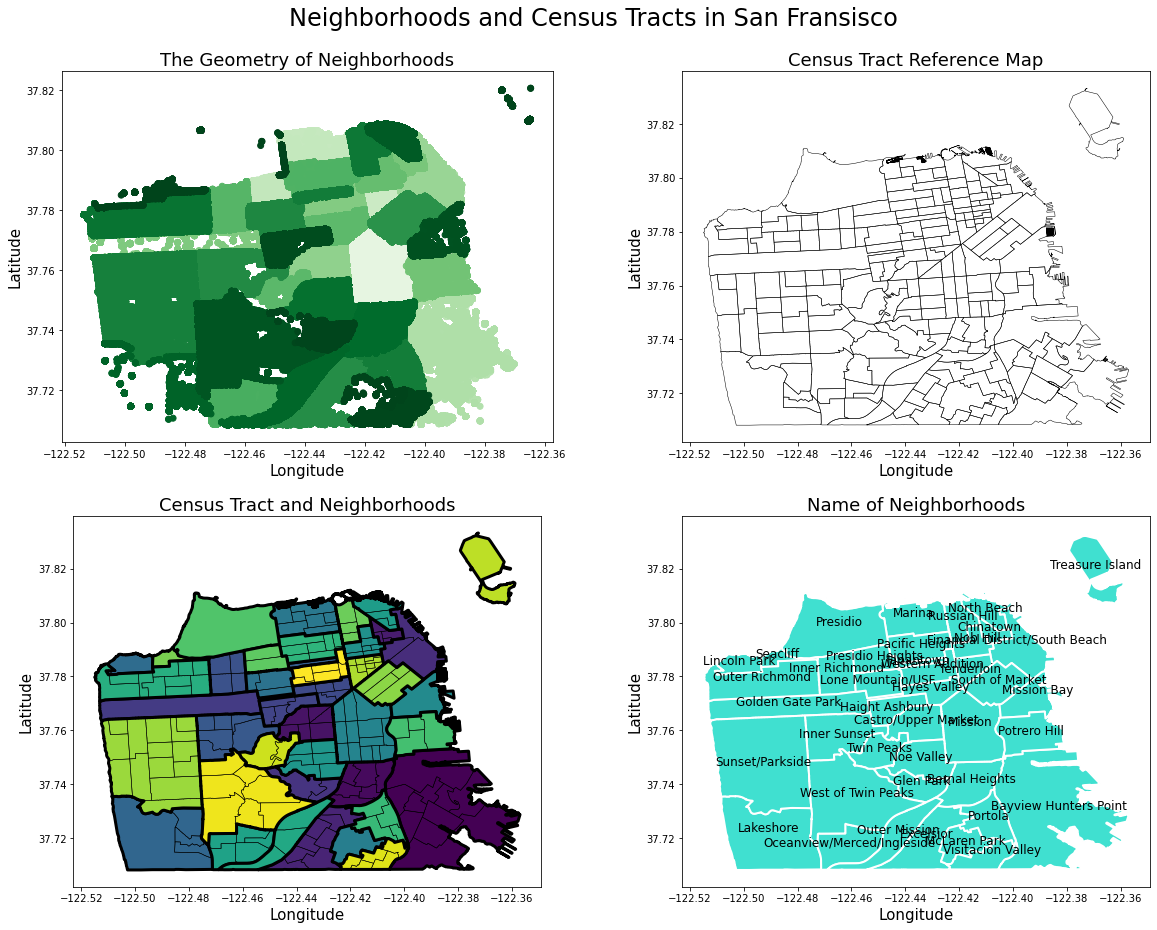

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2,nrows=2, sharex=False, sharey=False , figsize=(20,15))

# Point geometry
gdf_joined_crime_nbhd['geometry'].plot(ax=ax1,cmap='Greens')
ax1.set_title('The Geometry of Neighborhoods', fontsize=18)
ax1.set_xlabel('Longitude',{'fontsize':15})
ax1.set_ylabel('Latitude',{'fontsize':15})

# Polygon geometry
gdf_tract.plot(ax=ax2, linewidth=0.5, edgecolor='black', facecolor='None')
ax2.set_title('Census Tract Reference Map', fontsize=18)
ax2.set_xlabel('Longitude',{'fontsize':15})
ax2.set_ylabel('Latitude',{'fontsize':15})

# Polygon geometry
gdf_nbhd.plot(ax=ax3, linewidth=3, edgecolor='black', column='neighborhood',cmap='viridis')
gdf_tract.plot(ax=ax3, linewidth=0.5, edgecolor='black', facecolor='None')
ax3.set_title('Census Tract and Neighborhoods', fontsize=18)
ax3.set_xlabel('Longitude',{'fontsize':15})
ax3.set_ylabel('Latitude',{'fontsize':15})

# Polygon geometry
gdf_nbhd['matching'] = gdf_nbhd['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf_nbhd['matching']=gdf_nbhd['matching'].apply(lambda x: x[0])
gdf_nbhd.plot(ax=ax4,linewidth=2, edgecolor='white',facecolor='turquoise')
ax4.set_title('Name of Neighborhoods', fontsize=18)
ax4.set_xlabel('Longitude',{'fontsize':15})
ax4.set_ylabel('Latitude',{'fontsize':15})

for x in list(gdf_nbhd.index):
    plt.annotate(s=gdf_nbhd.iloc[x]['neighborhood'], xy=gdf_nbhd.iloc[x]['matching'],horizontalalignment='center',fontsize=12)

gdf_nbhd = gdf_nbhd.drop(['matching'], axis=1)

plt.suptitle('Neighborhoods and Census Tracts in San Fransisco',y=0.94,fontsize=24)
plt.show()

### Distibution of Crime Categories in Neighborhoods

In order to analyze the distribution of 39 crime categories in different neighborhoods, we use use 2D Kernel Density Estimation plots. The below plots demonstrate that most of the crimes are mainly commited in the north eastern neighborhoods of San Fransisco, and have similar patterns in other neighborhoods.

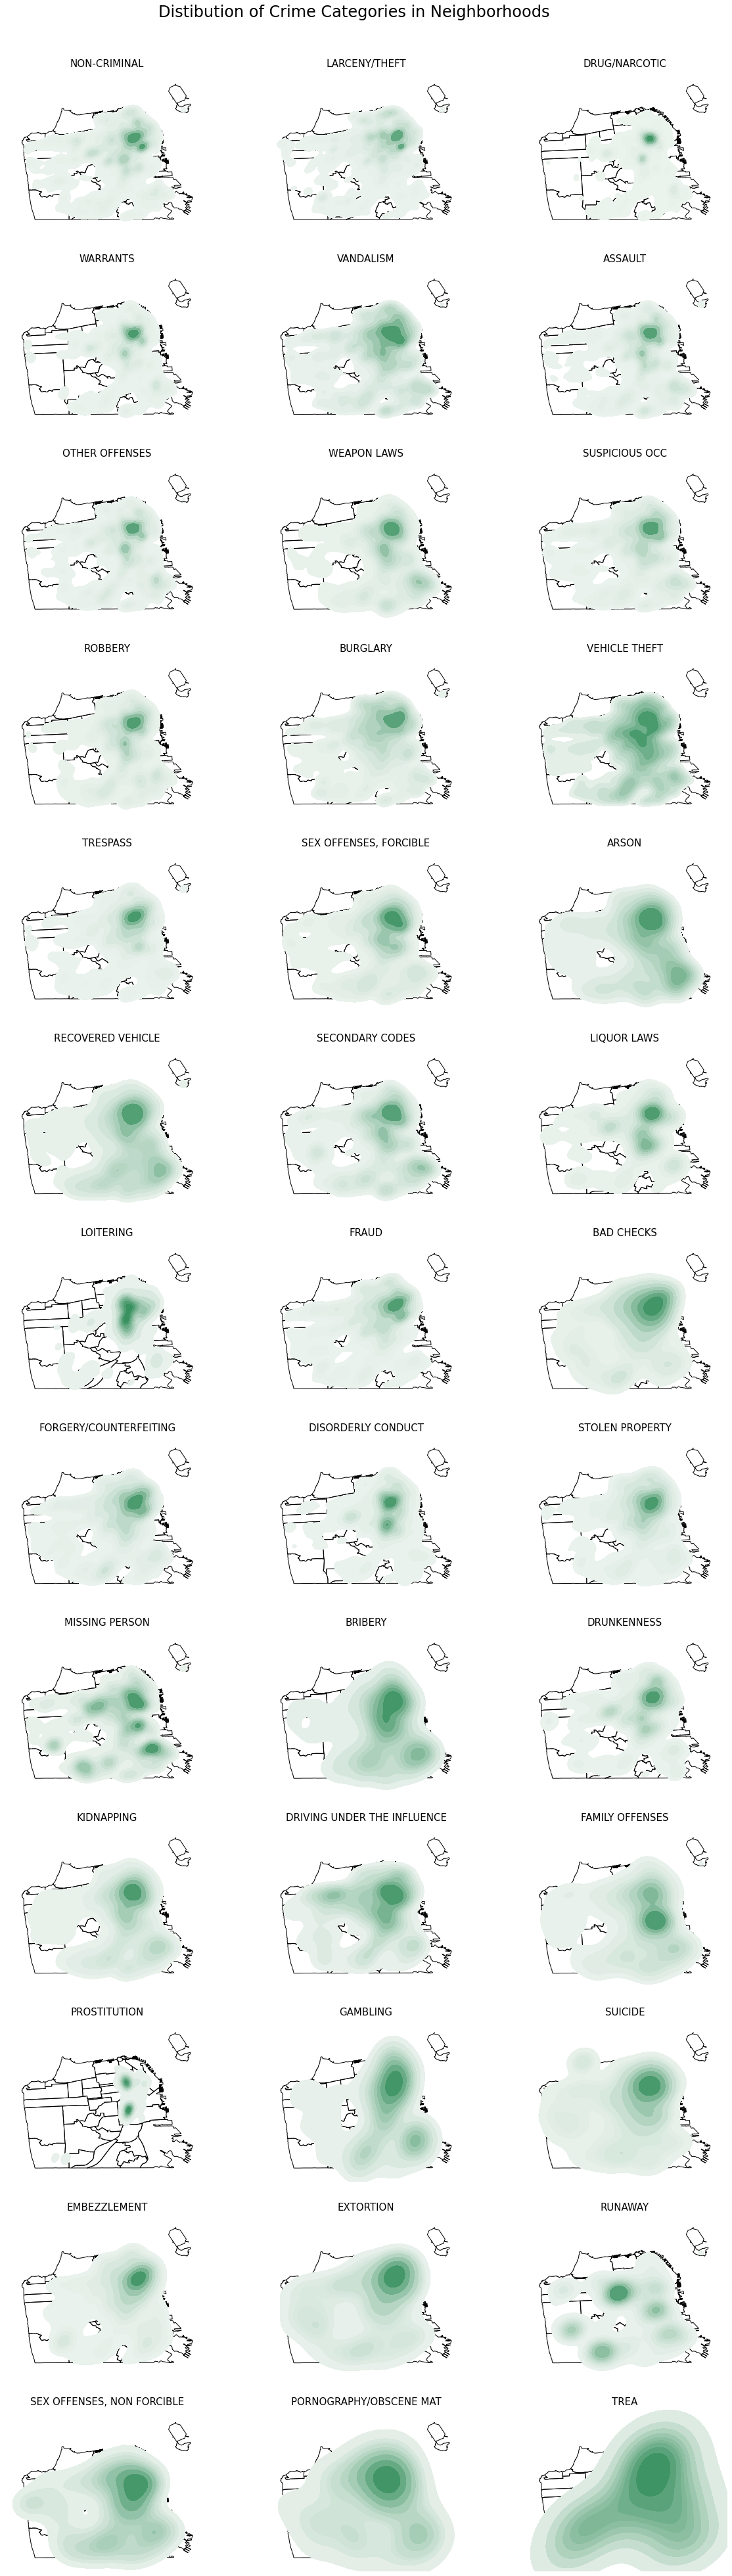

In [13]:
fig, axes  = plt.subplots(ncols=3,nrows=13, sharex=False, sharey=False , figsize=(20,70))  #15, 50
subplots=[[a,b] for a in range(0,13) for b in range(0,3)]

k=0
for x in gdf_joined_crime_nbhd['category'].unique():
    a,b=subplots[k]
    gplt.kdeplot(gdf_joined_crime_nbhd[gdf_joined_crime_nbhd['category'] == x], cmap=sns.light_palette("seagreen", as_cmap=True), 
                 shade=True, shade_lowest=False,ax=axes[a,b])  
    gplt.polyplot(gdf_nbhd,ax=axes[a,b])
    axes[a,b].set_title(f'{x}', fontsize=15);
    axes[a,b].set_xlabel('Longitude',{'fontsize':10})
    axes[a,b].set_ylabel('Latitude',{'fontsize':10})
    k=k+1

plt.suptitle('Distibution of Crime Categories in Neighborhoods',y=0.9,fontsize=24)
plt.show()

### Selection of the Data for 10  Crimes

Now we find the number of occured crimes in each category per total commited crimes and visualize the results.

In [13]:
# Percentage of the incidence of each crime category
df_joined_crime_nbhd['category']=df_joined_crime_nbhd['category'].apply(lambda x: 'SUSPICIOUS ACTIVITY' if x=='SUSPICIOUS OCC' else x)
crimes=round(100*df_joined_crime_nbhd.groupby('category').count()['incidntnum']/df_joined_crime_nbhd.shape[0],2)
crime_cat=pd.DataFrame({'Percentage':crimes}).reset_index()
crime_cat.columns=['Crime', 'Percentage']

In [14]:
import plotly.express as px

fig = px.scatter(crime_cat, x="Crime", y="Percentage",size="Percentage", size_max=70,
                color='Percentage',width=1000, height=800,color_continuous_scale='aggrnyl')

fig.update_yaxes(range=[-2, 25])

fig.update_traces(textposition='middle center', textfont_size=15)

fig.update_layout(
    title={
        'text': 'Rates of Different Categories of Crime',
        'y':0.96,
        'x':0.455,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Here we choose to analyze a subset of crime categories, and pick out 10 categories arbitrarily. These chosen categories can be easily changed and used for prediction by our developed models. Then we filter the data for selected categories and convert the result to geodataframe, gdf_crime_nbhd.

In [15]:
# Selecting 10 common categories
select=['LARCENY/THEFT', 'ASSAULT', 'WEAPON LAWS', 'DRUG/NARCOTIC', 'VEHICLE THEFT',
        'SUSPICIOUS ACTIVITY', 'VANDALISM','BURGLARY', 'ROBBERY', 'MISSING PERSON']

In [16]:
# Filtering data for selected categories
df_crime_nbhd=df_joined_crime_nbhd[df_joined_crime_nbhd['category'].isin(select)].copy()

In [17]:
# Converting df_crime_nh dataframe for selected categories to geodataframe
gdf_crime_nbhd=gpd.GeoDataFrame(
    df_crime_nbhd, geometry=gpd.points_from_xy(df_crime_nbhd['x'], df_crime_nbhd['y']))
gdf_crime_nbhd.crs = {'init': 'epsg:4326', 'no_defs': True}

In [18]:
df_joined_crime_nbhd.shape

(2213986, 18)

In [19]:
gdf_joined_crime_nbhd.shape

(2213986, 18)

In [20]:
df_crime_nbhd.shape

(1351912, 18)

In [21]:
gdf_crime_nbhd.shape

(1351912, 18)

### Age
Here we load the Age data.

In [22]:
df_age= pd.read_csv('ACS_17_5YR_B01002_with_ann.csv', header=1)
df_age.head(2)

Id         Id2  \
0  1400000US06075010100  6075010100   
1  1400000US06075010200  6075010200   

                                           Geography  \
0  Census Tract 101, San Francisco County, Califo...   
1  Census Tract 102, San Francisco County, Califo...   

  Estimate; Median age -- - Total: Margin of Error; Median age -- - Total:  \
0                             40.2                                     4.6   
1                             39.1                                     5.5   

  Estimate; Median age -- - Male Margin of Error; Median age -- - Male  \
0                           34.7                                   3.3   
1                           39.3                                   7.7   

  Estimate; Median age -- - Female Margin of Error; Median age -- - Female  
0                             44.9                                     3.3  
1                             37.9                                     7.6

We select the columns containing tract number and median age data and rename them.

In [23]:
df_age=df_age[['Geography','Estimate; Median age -- - Total:']]
df_age.columns=['tract', 'median_age']

We check if df_age contains null values.

In [24]:
df_age.isnull().sum()

tract         0
median_age    0
dtype: int64

Since median_age column contains non_numeric values, we replace these values with NaN. We will remove these null values later, after merging.

In [25]:
'-'  in df_age['median_age'].unique()

True

In [26]:
df_age['median_age']=df_age['median_age'].apply(lambda x: np.nan if x=='-' else float(x))

In [27]:
df_age.isnull().sum()

tract         0
median_age    2
dtype: int64

As we will later merge df_age to gdf_tract on tract column, we extract the census tract numbers from the string.

In [28]:
df_age['tract']=df_age['tract'].apply(lambda x: float(x.split()[2].split(',')[0]))
df_age.head(5)

tract  median_age
0  101.0        40.2
1  102.0        39.1
2  103.0        39.5
3  104.0        40.1
4  105.0        45.7

### Income
Here we load the Income data.

In [29]:
df_income=pd.read_csv('ACS_17_5YR_S1903_with_ann.csv', header=1)
df_income.head(2)

Id         Id2  \
0  1400000US06075010100  6075010100   
1  1400000US06075010200  6075010200   

                                           Geography  \
0  Census Tract 101, San Francisco County, Califo...   
1  Census Tract 102, San Francisco County, Califo...   

   Number; Estimate; Households  Number; Margin of Error; Households  \
0                          2035                                  122   
1                          2504                                  213   

   Percent Distribution; Estimate; Households  \
0                                        2035   
1                                        2504   

   Percent Distribution; Margin of Error; Households  \
0                                                122   
1                                                213   

  Median income (dollars); Estimate; Households  \
0                                         81509   
1                                        125238   

  Median income (dollars); Margin of Error; Households  \
0                                              19512     
1                                              22090     

   Number; Estimate; Households - One race-- - White  ...  \
0                                               1157  ...   
1                                               2180  ...   

   Percent Distribution; Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Living alone  \
0                                               33.0                                                               
1                                               30.2                                                               

  Percent Distribution; Margin of Error; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Living alone  \
0                                               10.6                                                                     
1                                               10.1                                                                     

  Median income (dollars); Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Living alone  \
0                                              94476                                                                 
1                                              78207                                                                 

  Median income (dollars); Margin of Error; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Living alone  \
0                                              19473                                                                        
1                                              54619                                                                        

  Number; Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone  \
0                                                201                                                    
1                                                284                                                    

   Number; Margin of Error; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone  \
0                                                 88                                                            
1                                                133                                                            

   Percent Distribution; Estimate; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone  \
0                                               16.8                                                                   
1                                               16.5                                                                   

  Percent Distribution; Margin of Error; NONFAMILY HOUSEHOLDS - Nonfamily households - Male householder - Not living alone  \
0                                                7.4                                             

We select the columns containing tract number, median income and no earners data, and rename them.

In [30]:
df_income=df_income[['Geography', 'Median income (dollars); Estimate; Households','Number; Estimate; FAMILY INCOME BY NUMBER OF EARNERS - No earners']]
df_income.columns=['tract', 'median_income', 'no_earners']

We check if df_income null values.

In [31]:
df_income.isnull().sum()

tract            0
median_income    0
no_earners       0
dtype: int64

Since median_income column contains non_numeric values, we replace these values with NaN. We will remove these null values later, after merging.

In [32]:
'-'  in df_income['median_income'].unique()

True

In [33]:
df_income['median_income']=df_income['median_income'].apply(lambda x: np.nan if x=='-' else float(x))

In [34]:
df_income.isnull().sum()

tract            0
median_income    2
no_earners       0
dtype: int64

As we will later merge df_income to gdf_tract on tract column, we extract the census tract numbers from the string.

In [35]:
df_income['tract']=df_income['tract'].apply(lambda x: float(x.split()[2].split(',')[0]))
df_income.head()

tract  median_income  no_earners
0  101.0        81509.0         111
1  102.0       125238.0         162
2  103.0       118210.0          62
3  104.0       106979.0          79
4  105.0       108063.0         136

### Population

Here we load the Population data.

In [36]:
df_population=pd.read_csv('ACS_17_5YR_DP05_with_ann.csv', header=1)
df_population.head(2)

Id         Id2  \
0  1400000US06075010100  6075010100   
1  1400000US06075010200  6075010200   

                                           Geography  \
0  Census Tract 101, San Francisco County, Califo...   
1  Census Tract 102, San Francisco County, Califo...   

   Estimate; SEX AND AGE - Total population  \
0                                      3967   
1                                      4363   

   Margin of Error; SEX AND AGE - Total population  \
0                                              251   
1                                              374   

   Percent; SEX AND AGE - Total population  \
0                                     3967   
1                                     4363   

  Percent Margin of Error; SEX AND AGE - Total population  \
0                                                (X)        
1                                                (X)        

   Estimate; SEX AND AGE - Total population - Male  \
0                                             1914   
1                                             2137   

   Margin of Error; SEX AND AGE - Total population - Male  \
0                                                263        
1                                                289        

  Percent; SEX AND AGE - Total population - Male  ...  \
0                                           48.2  ...   
1                                           49.0  ...   

  Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population  \
0                                               2953                          
1                                               3766                          

   Percent Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population  \
0                                                (X)                                           
1                                                (X)                                           

   Estimate; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male  \
0                                               1462                                   
1                                               1841                                   

  Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male  \
0                                                252                                         
1                                                265                                         

  Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male  \
0                                               49.5                                 
1                                               48.9                                 

  Percent Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male  \
0                                                6.8                                                 
1                                                5.6                                                 

  Estimate; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female  \
0                                               1491                                    
1                                               1925                                    

  Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female  \
0                                                221                                           
1                                                251                                           

  Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female  \
0                                               50.5                                   
1                                               51.1                                   

   Percent Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female  
0                   

In [37]:
df_population.columns

Index(['Id', 'Id2', 'Geography', 'Estimate; SEX AND AGE - Total population',
       'Margin of Error; SEX AND AGE - Total population',
       'Percent; SEX AND AGE - Total population',
       'Percent Margin of Error; SEX AND AGE - Total population',
       'Estimate; SEX AND AGE - Total population - Male',
       'Margin of Error; SEX AND AGE - Total population - Male',
       'Percent; SEX AND AGE - Total population - Male',
       ...
       'Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population',
       'Percent Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population',
       'Estimate; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male',
       'Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male',
       'Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male',
       'Percent Margin of Error; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over popul

We select the columns containing geography, number of male over 18, female over 18, total population over 18, total population, percentage of males, female population and male population.

In [38]:
df_population=df_population[['Geography',
                            'Estimate; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Male',
                            'Estimate; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population - Female',
                            'Percent; CITIZEN, VOTING AGE POPULATION - Citizen, 18 and over population',
                            'Estimate; SEX AND AGE - Total population',
                             'Percent; SEX AND AGE - Total population - Male',  
                             'Estimate; SEX AND AGE - Total population - Female',
                             'Estimate; SEX AND AGE - Total population - Male']]

We rename the columns, and as we will later merge df_population to gdf_tract on tract column, we extract the census tract numbers from the string.

In [39]:
df_population.columns=['tract','male-over 18', 'female-over 18', 'total- over 18',
                       'total_population', 'percent- male', 'female_population', 'male_population']
df_population['tract']=df_population['tract'].apply(lambda x: float(x.split()[2].split(',')[0]))
df_population.head()

tract  male-over 18  female-over 18  total- over 18  total_population  \
0  101.0          1462            1491            2953              3967   
1  102.0          1841            1925            3766              4363   
2  103.0          1949            1567            3516              4377   
3  104.0          1864            1856            3720              4645   
4  105.0          1040             943            1983              2691   

  percent- male  female_population  male_population  
0          48.2               2053             1914  
1          49.0               2226             2137  
2          53.4               2038             2339  
3          50.9               2282             2363  
4          52.2               1285             1406

### Evictions

We load the Evictions data.

In [40]:
df_eviction=pd.read_csv('Count_of_Eviction_Notices_By_Analysis_Neighborhood_and_Year.csv')

We convert the format of file year data to datetime, extract years, drop the file year column, and rename the columns. 

In [41]:
df_eviction['File Year']=pd.to_datetime(df_eviction['File Year'])
df_eviction['year']=df_eviction['File Year'].apply(lambda x: x.year)
df_eviction=df_eviction.drop(['File Year'], axis=1)
df_eviction.head()
df_eviction.columns= ['neighborhood', 'num_evictions', 'year']
df_eviction.head()

neighborhood  num_evictions  year
0     Presidio Heights             17  2003
1  Castro/Upper Market            116  2001
2         Hayes Valley             49  2002
3         Hayes Valley            177  1998
4       Bernal Heights             47  2005

### Crime Number Per Date, Neighborhood and Category

In order to fit the predictive models which we are going to build in the following parts with our date, we have to prepare our data. So we grid the data and count the number of crimes per date, neighborhood and crime category.

In [42]:
gdf_crime_number=gdf_crime_nbhd.groupby(['neighborhood', 'date', 'category']).count()
gdf_crime_number

incidntnum  descript  \
neighborhood          date       category                                    
Bayview Hunters Point 2003-01-01 ASSAULT                       9         9   
                                 BURGLARY                      1         1   
                                 DRUG/NARCOTIC                 1         1   
                                 LARCENY/THEFT                 6         6   
                                 MISSING PERSON                1         1   
...                                                          ...       ...   
Western Addition      2018-05-12 LARCENY/THEFT                 2         2   
                      2018-05-13 ASSAULT                       1         1   
                                 LARCENY/THEFT                 1         1   
                                 VANDALISM                     1         1   
                      2018-05-14 SUSPICIOUS ACTIVITY           1         1   

                                                      dayofweek  time  \
neighborhood          date       category                               
Bayview Hunters Point 2003-01-01 ASSAULT                      9     9   
                                 BURGLARY                     1     1   
                                 DRUG/NARCOTIC                1     1   
                                 LARCENY/THEFT                6     6   
                                 MISSING PERSON               1     1   
...                                                         ...   ...   
Western Addition      2018-05-12 LARCENY/THEFT                2     2   
                      2018-05-13 ASSAULT                      1     1   
                                 LARCENY/THEFT                1     1   
                                 VANDALISM                    1     1   
                      2018-05-14 SUSPICIOUS ACTIVITY          1     1   

                                                      pddistrict  resolution  \
neighborhood          date       category                                      
Bayview Hunters Point 2003-01-01 ASSAULT                       9           9   
                                 BURGLARY                      1           1   
                                 DRUG/NARCOTIC                 1           1   
                                 LARCENY/THEFT                 6           6   
                                 MISSING PERSON                1           1   
...                                                          ...         ...   
Western Addition      2018-05-12 LARCENY/THEFT                 2           2   
                      2018-05-13 ASSAULT                       1           1   
                                 LARCENY/THEFT                 1           1   
                                 VANDALISM                     1           1   
                      2018-05-14 SUSPICIOUS ACTIVITY           1           1   

                                                      address  x  y  location  \
neighborhood          date       category                                       
Bayview Hunters Point 2003-01-01 ASSAULT                    9  9  9         9   
                                 BURGLARY                   1  1  1         1   
                                 DRUG/NARCOTIC              1  1  1         1   
                                 LARCENY/THEFT              6  6  6         6   
                                 MISSING PERSON             1  1  1         1   
...                                                       ... .. ..       ...   
Western Addition      2018-05-12 LARCENY/THEFT              2  2  2         2   
                      2018-05-13 ASSAULT                    1  1  1         1   
                                 LARCENY/THEFT              1  1  1         1   
                                 VANDALISM                  1  1  1         1   
                      2018-05-14 SUSPICIOUS ACTIVITY        1  1  1         

Now we change the frequency of our data to day and if no crime occurred at a given neighborhood or date, we fill the missing data with zero.

In [43]:
gdf_crime_number= gdf_crime_number.pivot_table(index='date', columns=['neighborhood', 'category'])
gdf_crime_number=gdf_crime_number.asfreq('D')
gdf_crime_number=gdf_crime_number.fillna(0).stack(['neighborhood', 'category'])[['address']]
gdf_crime_number.columns=['crime_number']
gdf_crime_number

crime_number
date       neighborhood          category                         
2003-01-01 Bayview Hunters Point ASSAULT                       9.0
                                 BURGLARY                      1.0
                                 DRUG/NARCOTIC                 1.0
                                 LARCENY/THEFT                 6.0
                                 MISSING PERSON                1.0
...                                                            ...
2018-05-15 Western Addition      ROBBERY                       0.0
                                 SUSPICIOUS ACTIVITY           0.0
                                 VANDALISM                     0.0
                                 VEHICLE THEFT                 0.0
                                 WEAPON LAWS                   0.0

[2296126 rows x 1 columns]

Here we show the total number of all crime categories in each year in a rosechart.

In [44]:
c = df_joined_crime_nbhd['year'].value_counts().index.tolist()
d = df_joined_crime_nbhd['year'].value_counts().values.tolist()

rosechart = Pie(init_opts=opts.InitOpts(width='1000px', height='500px'))

color_series = 4*[ 'coral', 'teal', 'limegreen','royalblue', 'mediumpurple',
                   'turquoise', 'violet','greenyellow','deeppink','lightslategrey',
                  'peru', 'gold','mediumslateblue', 'lightseagreen','lawngreen','hotpink']
rosechart.set_colors(color_series)

rosechart.add("", [list(z) for z in zip(c, d)],
        radius=["20%", "95%"],  
        center=["50%", "57%"],   
        rosetype="area")

rosechart.set_global_opts(title_opts=opts.TitleOpts(title=50* '\t' +'Total Number of Crime Categories Per Year'),
                     legend_opts=opts.LegendOpts(is_show=False),
                     toolbox_opts=opts.ToolboxOpts())

rosechart.set_series_opts(label_opts=opts.LabelOpts(is_show=True, position="inside", font_size=12, formatter="{b}",font_weight="bold", font_family="Arial"))

rosechart.render_notebook()

C:\Users\Soha\Anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning:

pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)



We plot a treemap to show total number of each crime category from 2003 to 2018. 

In [45]:
new=df_joined_crime_nbhd.groupby('category').count().reset_index()
new=new[['category', 'incidntnum']]
new.columns=['category', 'number_of_crimes']

In [46]:
fig=px.treemap(new, path=['category'], values='number_of_crimes', color='number_of_crimes', color_continuous_scale='tropic',
               labels='category', width=1000, height=800)

fig.update_traces(textposition='middle center', textfont_size=15)
fig.update_layout(
    title={
        'text': 'Number of Different Categories of Crimes',
        'y':0.96,
        'x':0.455,
        'xanchor': 'center',
        'yanchor': 'top'})

We show the percentage distribution of the crime categories which we have selected for prediction in a pie chart.

In [47]:
# Sorting the 10 selected common crimes
sorted_crimes=round(100*df_crime_nbhd.groupby('category').count()['incidntnum'].sort_values(ascending=False)/df_joined_crime_nbhd.shape[0],2)
sorted_10=sorted_crimes[:10]
sorted_10

category
LARCENY/THEFT          21.69
ASSAULT                 8.79
VEHICLE THEFT           5.71
DRUG/NARCOTIC           5.40
VANDALISM               5.24
BURGLARY                4.13
SUSPICIOUS ACTIVITY     3.63
MISSING PERSON          2.93
ROBBERY                 2.52
WEAPON LAWS             1.00
Name: incidntnum, dtype: float64

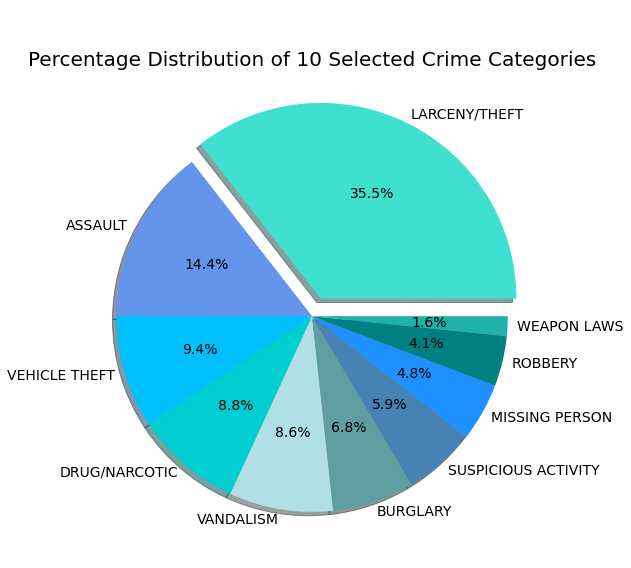

In [48]:
plt.figure(figsize=(9,9))
plt.pie(x=sorted_10.values,labels=sorted_10.index,
        pctdistance=0.6, labeldistance=1.05,autopct='%1.1f%%',
        explode=(0.1,0,0,0,0,0,0,0,0,0,),shadow=True,startangle=0,textprops={'fontsize':14},
        colors= ['turquoise', 'cornflowerblue', 'deepskyblue','darkturquoise', 'powderblue','cadetblue',
                 'steelblue','dodgerblue','teal','lightseagreen'])
plt.title('\n\nPercentage Distribution of 10 Selected Crime Categories',loc='center', fontsize=20)
plt.show()

We filter the 4 most commited crimes, and show the distribution of these crime categories per months and weekdays.

In [49]:
#Filtering the top 4 commited crimes
warnings.filterwarnings("ignore")
df_circles=df_joined_crime_nbhd[df_joined_crime_nbhd['category'].isin(list(df_joined_crime_nbhd['category'].value_counts().sort_values(ascending=False)[:4].index))]

df_circles['date']=pd.to_datetime(df_circles['date'])
df_circles['month']=df_circles['date'].apply(lambda x:x.month)
df_circles['month']=df_circles['month'].apply(lambda x:calendar.month_abbr[x])

df_circles['day_abbr']=df_circles['dayofweek'].apply(lambda x: 'Mon' if x=='Monday' else 'Tue' if x=='Tuesday'
                                     else 'Wed' if x=='Wednesday' else 'Thur' if x=='Thursday' 
                                     else 'Fri' if x=='Friday' else 'Sat' if x=='Saturday'
                                     else 'Sun')

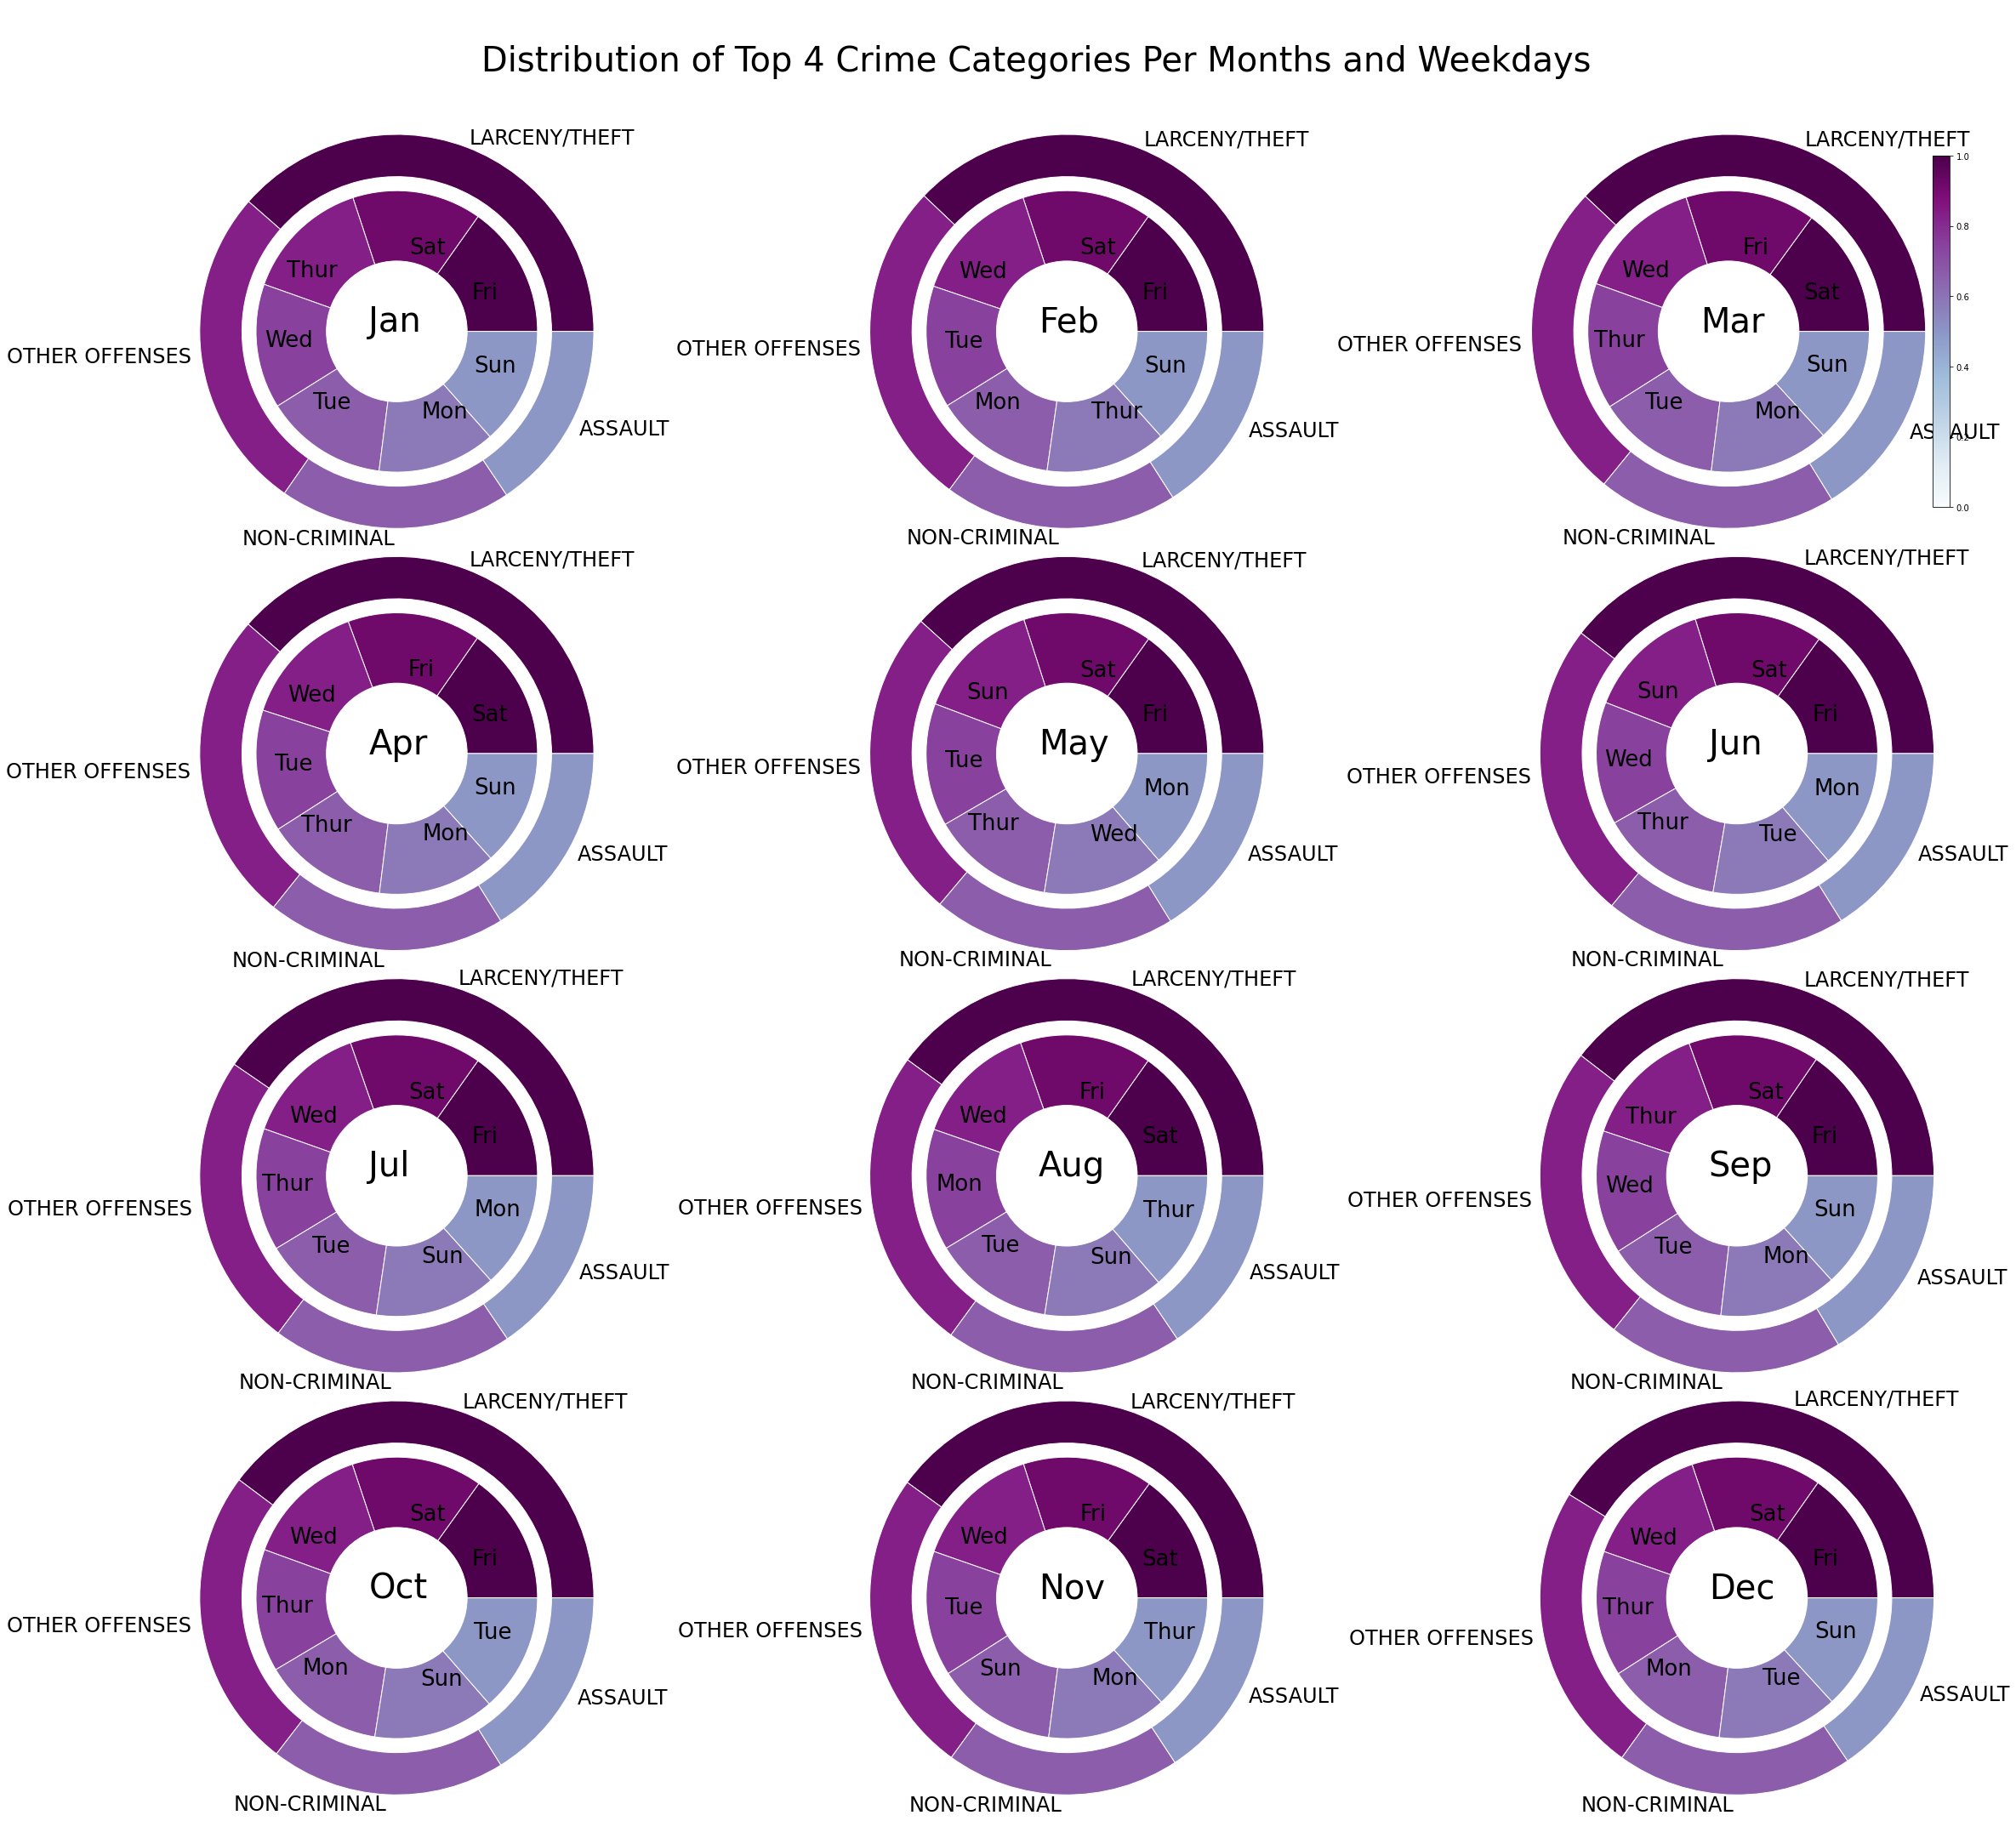

In [50]:
months =df_circles['month'].unique()
month_lookup = list(calendar.month_abbr)

plt.figure(figsize=(40,35))

a=1
for x in sorted(months, key=month_lookup.index):

    plt.subplot(4,3,a)
    df=df_circles[df_circles['month']==x]
    subgroup_names=list(df['day_abbr'].value_counts().index)
    subgroup_size=list(df['day_abbr'].value_counts().values)
    
    group_names=list(df['category'].value_counts().index)
    group_size=list(df['category'].value_counts().values)

    my_circle=plt.Circle( (0,0), 0.5, color='white')
    pie1,_=plt.pie(group_size, radius=1.4, labels=group_names,labeldistance=1.05,textprops={'fontsize':24},
                   colors=cm.BuPu.reversed()(np.linspace(0, 0.5, 4)))
    
    plt.setp( pie1, width=0.3, edgecolor='white')
    pie2,_=plt.pie(subgroup_size, radius=1.4-0.4, labels=subgroup_names, labeldistance=0.6,textprops={'fontsize':26},
                  colors=cm.BuPu.reversed()(np.linspace(0, 0.5, 7)))
    plt.setp( pie2, width=0.9, edgecolor='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    p.gca().annotate(f'{x}',xy=(-0.2,0), fontsize=40)
    
    a=a+1
       
plt.suptitle('\nDistribution of Top 4 Crime Categories Per Months and Weekdays\n',y=0.95,fontsize=40)

plt.subplot(4,3,3)
plt.colorbar(cm.ScalarMappable(cmap=cm.BuPu))
plt.show()

We can see that in Jan, Feb, May, Jun, Jul, Sep, Oct and Dec, crimes were mainly commited on Friday, while in Mar, Apr, Aug and Nov, crimes were mainly commited on Sunday. 

### Merging the Data

As the demographic data are included in census tracts, we merge age, income and population data with gdf_tract.

In [51]:
gdf_tract=pd.merge(pd.merge(pd.merge(gdf_tract,df_age,on='tract', how='left'), df_population, on='tract', how='left'),df_income, on='tract', how='left')
gdf_tract.head(2)

geoid      neighborhood    shape_area    shape_len  tract  \
0  06075016400      Hayes Valley  3.326589e+06  7589.679396  164.0   
1  06075016100  Western Addition  3.970259e+06  8525.808755  161.0   

                                            geometry  median_age  \
0  POLYGON ((-122.43247 37.77376, -122.43411 37.7...        35.2   
1  POLYGON ((-122.42354 37.77967, -122.42345 37.7...        38.5   

   male-over 18  female-over 18  total- over 18  total_population  \
0        1712.0          1756.0          3468.0            3915.0   
1        1736.0          2135.0          3871.0            5562.0   

  percent- male  female_population  male_population  median_income  no_earners  
0          48.5             2016.0           1899.0       119321.0         1.0  
1          44.9             3065.0           2497.0        24041.0       385.0

We fill the null values with zero.

In [52]:
gdf_tract.isnull().sum()

geoid                0
neighborhood         0
shape_area           0
shape_len            0
tract                0
geometry             0
median_age           5
male-over 18         5
female-over 18       5
total- over 18       5
total_population     5
percent- male        5
female_population    5
male_population      5
median_income        5
no_earners           5
dtype: int64

In [53]:
gdf_tract=gdf_tract.fillna(0)

Before merging gdf_tract with gdf_nbhd, we group the data in gdf_tract for each neighborhood and perform aggregation techniques on the columns. 

For shape_area, total_population, total- over 18,female_population and male_population columns, we use sum aggregation function. For median_age, median_income and percent- male columns, we use median aggregation function. Afterwards, we merge gdf_tract with gdf_nbhd on the neighborhood columns.

In [54]:
gdf_tract['percent- male']=gdf_tract['percent- male'].apply(lambda x: float(x))

gdf_nbhd=pd.merge(gdf_nbhd, pd.merge(gdf_tract.groupby('neighborhood').sum()[['shape_area', 'total_population', 'total- over 18','female_population','male_population']].reset_index(),
         gdf_tract.groupby('neighborhood').median()[['median_age', 'median_income', 'percent- male']].reset_index(),
        on='neighborhood',how='left'), on ='neighborhood', how='left')

gdf_nbhd.head(2)

neighborhood                                           geometry  \
0  Bayview Hunters Point  POLYGON ((-122.38158 37.75307, -122.38157 37.7...   
1         Bernal Heights  POLYGON ((-122.40361 37.74934, -122.40378 37.7...   

     shape_area  total_population  total- over 18  female_population  \
0  1.442175e+08           36939.0         22803.0            19074.0   
1  3.005083e+07           26705.0         18611.0            12751.0   

   male_population  median_age  median_income  percent- male  
0          17865.0       35.10        54375.0           47.4  
1          13954.0       38.95       127656.5           51.4

Now we merge gdf_crime_number and gdf_nbhd obtained from the above cell, add year column, and merge the result with df_eviction.

In [55]:
gdf_crime_number= pd.merge(gdf_crime_number.reset_index(), gdf_nbhd, on = 'neighborhood', how='left')
gdf_crime_number['year']= gdf_crime_number['date'].apply(lambda x: x.year)
gdf_crime_number= pd.merge(gdf_crime_number, df_eviction , on =['neighborhood','year'], how='left')
gdf_crime_number.head(2)

date           neighborhood  category  crime_number  \
0 2003-01-01  Bayview Hunters Point   ASSAULT           9.0   
1 2003-01-01  Bayview Hunters Point  BURGLARY           1.0   

                                            geometry    shape_area  \
0  POLYGON ((-122.38158 37.75307, -122.38157 37.7...  1.442175e+08   
1  POLYGON ((-122.38158 37.75307, -122.38157 37.7...  1.442175e+08   

   total_population  total- over 18  female_population  male_population  \
0           36939.0         22803.0            19074.0          17865.0   
1           36939.0         22803.0            19074.0          17865.0   

   median_age  median_income  percent- male  year  num_evictions  
0        35.1        54375.0           47.4  2003           39.0  
1        35.1        54375.0           47.4  2003           39.0

In [56]:
gdf_crime_number.shape

(2296126, 15)

In [57]:
gdf_crime_number.isnull().sum()

date                      0
neighborhood              0
category                  0
crime_number              0
geometry                  0
shape_area                0
total_population          0
total- over 18            0
female_population         0
male_population           0
median_age                0
median_income             0
percent- male             0
year                      0
num_evictions        247137
dtype: int64

In [58]:
gdf_crime_number=gdf_crime_number.fillna(0)

Here we add two new features to gdf_crime_number; Evictions per every 1000 member of population and Ratio of population older than 18 years.

In [59]:
#Evictions per every 1000 member of population
gdf_crime_number['ratio_eviction_population'] = gdf_crime_number['num_evictions']/gdf_crime_number['total_population']*1000
#Ratio of population older than 18 years
gdf_crime_number['ratio_over18_population'] = gdf_crime_number['total- over 18']/gdf_crime_number['total_population']*100

We add dayofweek, season, quarter and weeked columns to gdf_crime_number.

In [60]:
#dayofweek
gdf_crime_number['dayofweek']= gdf_crime_number['date'].apply(lambda x: x.dayofweek)
#season
gdf_crime_number['season']=(gdf_crime_number['date'] - pd.DateOffset(months=1)).apply(lambda x: x.quarter)
#quarter
gdf_crime_number['quarter']=gdf_crime_number['date'].apply(lambda x: x.quarter)
#weekend
gdf_crime_number['weekend']= gdf_crime_number['dayofweek'].apply(lambda x: 1 if x in[5,6] else 0)

Moving Sum function operates over a moving window of values. For each Window, the Moving Sum returns the sum of values found in the window. For each crime category and neighborhood, we calculate the weekly rolling sum of crime numbers and put the results in gdf_crime_number_weekly.

In [61]:
# Weekly rolling 
gdf_crime_number_weekly= gdf_crime_number.copy()
new=pd.DataFrame()

for x in gdf_crime_number['category'].unique():
    for y in gdf_crime_number['neighborhood'].unique():
        selected_1= gdf_crime_number[(gdf_crime_number['category']==x) & (gdf_crime_number['neighborhood']==y)][['date','neighborhood','category','crime_number']]
        selected_1['date']= pd.to_datetime(selected_1['date'])
        
        selected_2 = selected_1[['date','crime_number']].rolling(7, center=False, on='date').sum().fillna(method='bfill')
        selected_2.columns= ['date','crime_number_weekly_rolling']
        selected_2['date']= pd.to_datetime(selected_2['date'])
        
        selected_1 = pd.merge(selected_1, selected_2, on='date', how='left').drop('crime_number', axis=1)
        new = pd.concat([new, selected_1], ignore_index=True)

In [62]:
gdf_crime_number_weekly = pd.merge(gdf_crime_number_weekly,new, on=['date','neighborhood','category'], how='left')

We calculate  weekly crime density per population and area and add them to gdf_crime_number_weekly.

In [63]:
# weekly crime_density per population
gdf_crime_number_weekly['weekly_crime_density_per_pop']=gdf_crime_number_weekly['crime_number_weekly_rolling']/gdf_crime_number_weekly['total_population']
# weekly crime density per area
gdf_crime_number_weekly['weekly_crime_density_per_area']=gdf_crime_number_weekly['crime_number_weekly_rolling']/gdf_crime_number_weekly['shape_area']

In [64]:
gdf_crime_number_weekly.head(2)

date           neighborhood  category  crime_number  \
0 2003-01-01  Bayview Hunters Point   ASSAULT           9.0   
1 2003-01-01  Bayview Hunters Point  BURGLARY           1.0   

                                            geometry    shape_area  \
0  POLYGON ((-122.38158 37.75307, -122.38157 37.7...  1.442175e+08   
1  POLYGON ((-122.38158 37.75307, -122.38157 37.7...  1.442175e+08   

   total_population  total- over 18  female_population  male_population  ...  \
0           36939.0         22803.0            19074.0          17865.0  ...   
1           36939.0         22803.0            19074.0          17865.0  ...   

   num_evictions  ratio_eviction_population  ratio_over18_population  \
0           39.0                   1.055795                61.731503   
1           39.0                   1.055795                61.731503   

   dayofweek  season  quarter  weekend  crime_number_weekly_rolling  \
0          2       4        1        0                         46.0   
1          2       4        1        0                         11.0   

   weekly_crime_density_per_pop  weekly_crime_density_per_area  
0                      0.001245                   3.189626e-07  
1                      0.000298                   7.627366e-08  

[2 rows x 24 columns]

Again, we use the Moving Sum function, but this time we calculate the monthly rolling sum of crime numbers and put the results in gdf_crime_number_monthly.

In [65]:
# Monthly rolling 
gdf_crime_number_monthly= gdf_crime_number.copy()
new=pd.DataFrame()

for x in gdf_crime_number['category'].unique():
    for y in gdf_crime_number['neighborhood'].unique():
        selected_1= gdf_crime_number[(gdf_crime_number['category']==x) & (gdf_crime_number['neighborhood']==y)][['date','neighborhood','category','crime_number']]
        selected_1['date']= pd.to_datetime(selected_1['date'])
        
        selected_2 = selected_1[['date','crime_number']].rolling(30, center=False, on='date').sum().fillna(method='bfill')
        selected_2.columns= ['date','crime_number_monthly_rolling']
        selected_2['date']= pd.to_datetime(selected_2['date'])
        
        selected_1 = pd.merge(selected_1, selected_2, on='date', how='left').drop('crime_number', axis=1)
        new = pd.concat([new, selected_1], ignore_index=True)

In [66]:
gdf_crime_number_monthly = pd.merge(gdf_crime_number_monthly,new, on=['date','neighborhood','category'], how='left')

We calculate monthly crime density per population and area and add them to gdf_crime_number_monthly.

In [67]:
gdf_crime_number_monthly.shape

(2296126, 22)

In [68]:
gdf_crime_number_weekly.shape

(2296126, 24)

In [69]:
# monthly crime_density per population
gdf_crime_number_monthly['monthly_crime_density_per_pop']=gdf_crime_number_monthly['crime_number_monthly_rolling']/gdf_crime_number_monthly['total_population']
# monthly crime density per area
gdf_crime_number_monthly['monthly_crime_density_per_area']=gdf_crime_number_monthly['crime_number_monthly_rolling']/gdf_crime_number_monthly['shape_area']

We select monthly & weekly crime density per population & area calculated above, and add them to gdf_crime_number.

In [70]:
gdf_crime_number['monthly_crime_density_per_pop'] = gdf_crime_number_monthly['monthly_crime_density_per_pop']
gdf_crime_number['monthly_crime_density_per_area'] = gdf_crime_number_monthly['monthly_crime_density_per_area']

gdf_crime_number['weekly_crime_density_per_pop'] = gdf_crime_number_weekly['weekly_crime_density_per_pop']
gdf_crime_number['weekly_crime_density_per_area'] = gdf_crime_number_weekly['weekly_crime_density_per_area']

gdf_crime_number.head(2)

date           neighborhood  category  crime_number  \
0 2003-01-01  Bayview Hunters Point   ASSAULT           9.0   
1 2003-01-01  Bayview Hunters Point  BURGLARY           1.0   

                                            geometry    shape_area  \
0  POLYGON ((-122.38158 37.75307, -122.38157 37.7...  1.442175e+08   
1  POLYGON ((-122.38158 37.75307, -122.38157 37.7...  1.442175e+08   

   total_population  total- over 18  female_population  male_population  ...  \
0           36939.0         22803.0            19074.0          17865.0  ...   
1           36939.0         22803.0            19074.0          17865.0  ...   

   ratio_eviction_population  ratio_over18_population  dayofweek  season  \
0                   1.055795                61.731503          2       4   
1                   1.055795                61.731503          2       4   

   quarter  weekend  monthly_crime_density_per_pop  \
0        1        0                       0.003411   
1        1        0                       0.001381   

   monthly_crime_density_per_area  weekly_crime_density_per_pop  \
0                    8.736801e-07                      0.001245   
1                    3.536324e-07                      0.000298   

   weekly_crime_density_per_area  
0                   3.189626e-07  
1                   7.627366e-08  

[2 rows x 25 columns]

In [71]:
gdf_crime_number.shape

(2296126, 25)

Let's visualize the number of commited crimes per quarters and weekdays.

In [72]:
quarter=gdf_crime_number.copy()
quarter['quarter']= quarter['quarter'].apply(lambda x : 'Jan-Feb-Mar' if x==1 else 'Apr-May-Jun' if x==2 
                                             else 'Jul-Aug-Sep' if x==3 else 'Oct-Nov-Dec')

quarter['weekday']=quarter['date'].apply(lambda x:datetime.strftime(x,'%a'))

In [73]:
fig=px.sunburst(data_frame=quarter.groupby(['quarter', 'weekday']).sum().reset_index(),
                path=['quarter','weekday'], color='crime_number', color_continuous_scale='geyser')
fig.update_layout(
    title={
        'text': 'Number of Commited Crimes Per Quarters and Weekdays',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

### Feature Distribution Maps

In order to plot feature distribution maps, first we create gdf_nbhd_eviction. We start with adding the percentage of over18 population to gdf_nbhd.
 Then we group gdf_crime_number by neighborhood column, find the sum of number of evictions, merge it into gdf_nbhd, and find the ratio of evictions to population for each neighborhood.

In [74]:
# Adding ratio_over18_population to gdf_nbhd
gdf_nbhd['ratio_over18_population']= gdf_nbhd['total- over 18']/gdf_nbhd['total_population']*100
gdf_nbhd.head(2)

neighborhood                                           geometry  \
0  Bayview Hunters Point  POLYGON ((-122.38158 37.75307, -122.38157 37.7...   
1         Bernal Heights  POLYGON ((-122.40361 37.74934, -122.40378 37.7...   

     shape_area  total_population  total- over 18  female_population  \
0  1.442175e+08           36939.0         22803.0            19074.0   
1  3.005083e+07           26705.0         18611.0            12751.0   

   male_population  median_age  median_income  percent- male  \
0          17865.0       35.10        54375.0           47.4   
1          13954.0       38.95       127656.5           51.4   

   ratio_over18_population  
0                61.731503  
1                69.691069

In [75]:
gdf_crime_number.head(1)

date           neighborhood category  crime_number  \
0 2003-01-01  Bayview Hunters Point  ASSAULT           9.0   

                                            geometry    shape_area  \
0  POLYGON ((-122.38158 37.75307, -122.38157 37.7...  1.442175e+08   

   total_population  total- over 18  female_population  male_population  ...  \
0           36939.0         22803.0            19074.0          17865.0  ...   

   ratio_eviction_population  ratio_over18_population  dayofweek  season  \
0                   1.055795                61.731503          2       4   

   quarter  weekend  monthly_crime_density_per_pop  \
0        1        0                       0.003411   

   monthly_crime_density_per_area  weekly_crime_density_per_pop  \
0                    8.736801e-07                      0.001245   

   weekly_crime_density_per_area  
0                   3.189626e-07  

[1 rows x 25 columns]

In [76]:
gdf_nbhd_eviction= pd.merge(gdf_nbhd
         ,gdf_crime_number[['neighborhood', 'num_evictions','year']].drop_duplicates().groupby(['neighborhood']).sum()['num_evictions']
         ,on='neighborhood'
         ,how='left')

# Ratio of eviction to population per neighborhood
gdf_nbhd_eviction['ratio_eviction_population'] = gdf_nbhd_eviction['num_evictions'] / gdf_nbhd_eviction['total_population']
gdf_nbhd_eviction.head(2)

neighborhood                                           geometry  \
0  Bayview Hunters Point  POLYGON ((-122.38158 37.75307, -122.38157 37.7...   
1         Bernal Heights  POLYGON ((-122.40361 37.74934, -122.40378 37.7...   

     shape_area  total_population  total- over 18  female_population  \
0  1.442175e+08           36939.0         22803.0            19074.0   
1  3.005083e+07           26705.0         18611.0            12751.0   

   male_population  median_age  median_income  percent- male  \
0          17865.0       35.10        54375.0           47.4   
1          13954.0       38.95       127656.5           51.4   

   ratio_over18_population  num_evictions  ratio_eviction_population  
0                61.731503          757.0                   0.020493  
1                69.691069          695.0                   0.026025

Also we add the ratio of crimes to population for each neighborhood to gdf_nbhd_crime defined below.

In [77]:
gdf_nbhd_crime= pd.merge(gdf_nbhd
         ,gdf_crime_number.groupby(['neighborhood']).sum()['crime_number']
         , on='neighborhood'
         ,how='left')

# Ratio of crimes to population per neighborhood
gdf_nbhd_crime['ratio_crime_population'] = gdf_nbhd_crime['crime_number'] / gdf_nbhd_crime['total_population']

gdf_nbhd_crime.head(2)

neighborhood                                           geometry  \
0  Bayview Hunters Point  POLYGON ((-122.38158 37.75307, -122.38157 37.7...   
1         Bernal Heights  POLYGON ((-122.40361 37.74934, -122.40378 37.7...   

     shape_area  total_population  total- over 18  female_population  \
0  1.442175e+08           36939.0         22803.0            19074.0   
1  3.005083e+07           26705.0         18611.0            12751.0   

   male_population  median_age  median_income  percent- male  \
0          17865.0       35.10        54375.0           47.4   
1          13954.0       38.95       127656.5           51.4   

   ratio_over18_population  crime_number  ratio_crime_population  
0                61.731503       86494.0                2.341536  
1                69.691069       28943.0                1.083805

Now we use the above mentioned geodataframes and study the distribution of different features in neighborhoods and census tracts in SF. 

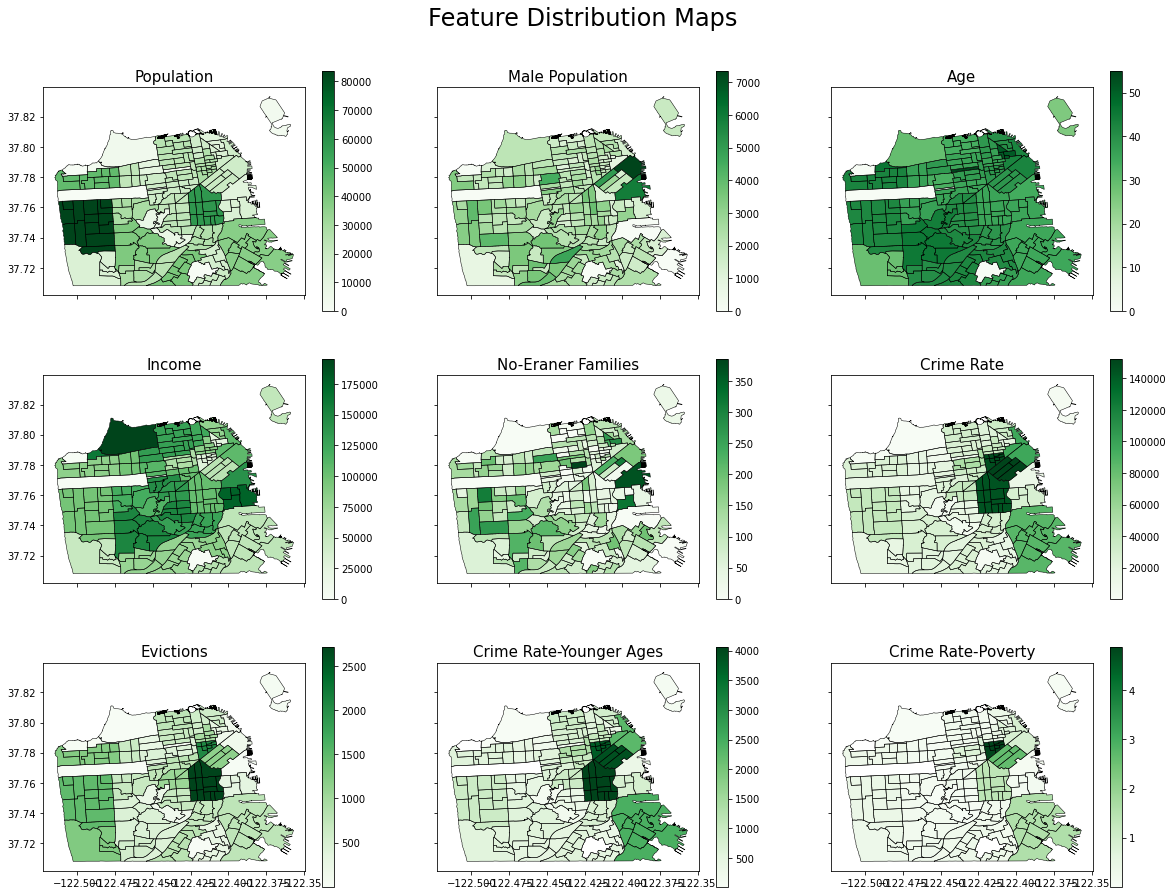

In [78]:
fig, axes  = plt.subplots(ncols=3,nrows=3, sharex=True, sharey=True , figsize=(20,15))

subplots=[[a,b] for a in range(0,3) for b in range(0,3)]

a,b=subplots[0]
gdf_nbhd.plot(ax=axes[a,b], column='total_population',legend=True, cmap='Greens')
gdf_tract.plot(ax=axes[a,b], linewidth=0.5, edgecolor='black', facecolor='None')
axes[a,b].set_title('Population', fontsize=15)


a,b=subplots[1]
gdf_tract.plot(ax=axes[a,b],column='male_population',legend=True, cmap='Greens')
gdf_tract.plot(ax=axes[a,b], linewidth=0.5, edgecolor='black', facecolor='None')
axes[a,b].set_title('Male Population', fontsize=15)


a,b=subplots[2]
gdf_nbhd.plot(ax=axes[a,b], column='median_age',legend=True, cmap='Greens')
gdf_tract.plot(ax=axes[a,b], linewidth=0.5, edgecolor='black', facecolor='None')
axes[a,b].set_title('Age', fontsize=15)


a,b=subplots[3]
gdf_nbhd.plot(ax=axes[a,b], column='median_income',legend=True, cmap='Greens')
gdf_tract.plot(ax=axes[a,b], linewidth=0.5, edgecolor='black', facecolor='None')
axes[a,b].set_title('Income', fontsize=15)


a,b=subplots[4]
gdf_tract.plot(ax=axes[a,b],column='no_earners',legend=True, cmap='Greens')
gdf_tract.plot(ax=axes[a,b], linewidth=0.5, edgecolor='black', facecolor='None')
axes[a,b].set_title('No-Eraner Families', fontsize=15)


a,b=subplots[5]
gdf_nbhd_crime.plot(ax=axes[a,b], column='crime_number',legend=True, cmap='Greens')
gdf_tract.plot(ax=axes[a,b], linewidth=0.5, edgecolor='black', facecolor='None')
axes[a,b].set_title('Crime Rate', fontsize=15)


a,b=subplots[6]
gdf_nbhd_eviction.plot(ax=axes[a,b], column='num_evictions',legend=True, cmap='Greens')
gdf_tract.plot(ax=axes[a,b], linewidth=0.5, edgecolor='black', facecolor='None')
axes[a,b].set_title('Evictions', fontsize=15)


a,b=subplots[7]
gdf_nbhd_crime['new_median_age']= gdf_nbhd_crime['median_age'].replace(0, np.nan)
gdf_nbhd_crime['crime_number_age']= gdf_nbhd_crime['crime_number']/gdf_nbhd_crime['new_median_age']
gdf_nbhd_crime.plot(ax=axes[a,b], column='crime_number_age',legend=True, cmap='Greens')
gdf_tract.plot(ax=axes[a,b], linewidth=0.5, edgecolor='black', facecolor='None')
axes[a,b].set_title('Crime Rate-Younger Ages', fontsize=15)
gdf_nbhd_crime=gdf_nbhd_crime.drop(['crime_number_age', 'new_median_age'], axis=1)


a,b=subplots[8]
gdf_nbhd_crime['new_median_income']= gdf_nbhd_crime['median_income'].replace(0, np.nan)
gdf_nbhd_crime['crime_number_income']= gdf_nbhd_crime['crime_number']/gdf_nbhd_crime['new_median_income']
gdf_nbhd_crime.plot(ax=axes[a,b], column='crime_number_income',legend=True, cmap='Greens')
gdf_tract.plot(ax=axes[a,b], linewidth=0.5, edgecolor='black', facecolor='None')
axes[a,b].set_title('Crime Rate-Poverty', fontsize=15)
gdf_nbhd_crime=gdf_nbhd_crime.drop(['crime_number_income', 'new_median_income'], axis=1)


plt.suptitle('Feature Distribution Maps',y=0.94,fontsize=24)
plt.show()

### Correlation Maps

We plot the correlation matrix for crime data, and seperately show the correlation of different features with number of crimes. 

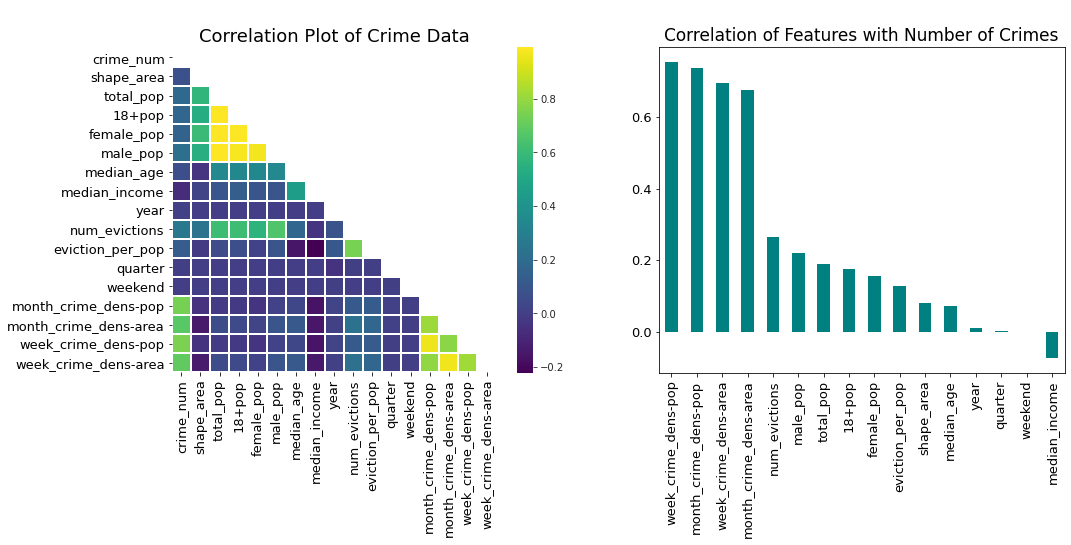

In [79]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(16,6))

corr = gdf_crime_number.drop([
                       'dayofweek','ratio_over18_population','season','percent- male'], axis=1).rename(columns=
                         {'monthly_crime_density_per_pop':'month_crime_dens-pop',
                          'monthly_crime_density_per_area':'month_crime_dens-area',
                          'weekly_crime_density_per_pop':'week_crime_dens-pop',
                          'weekly_crime_density_per_area':'week_crime_dens-area',
                          'ratio_eviction_population':'eviction_per_pop','crime_number':'crime_num',
                          'total_population' :'total_pop','total- over 18':'18+pop',
                          'female_population':'female_pop', 'male_population':'male_pop'}).corr()

plt.subplot(1,2,1)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, annot=False, cmap='viridis', linewidths=1)   
plt.title('\nCorrelation Plot of Crime Data', fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(1,2,2)
corr['crime_num'].sort_values(ascending=False).drop(['crime_num']).plot(kind='bar',color='teal')
plt.title('Correlation of Features with Number of Crimes',fontsize=17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

## Training Predictive Models

In order to build predictive models, we drop the null values in gdf_crime_number, sort rows by date and sort columns by names to easily handle  predictions.

In [80]:
gdf_crime_number.head(1)

date           neighborhood category  crime_number  \
0 2003-01-01  Bayview Hunters Point  ASSAULT           9.0   

                                            geometry    shape_area  \
0  POLYGON ((-122.38158 37.75307, -122.38157 37.7...  1.442175e+08   

   total_population  total- over 18  female_population  male_population  ...  \
0           36939.0         22803.0            19074.0          17865.0  ...   

   ratio_eviction_population  ratio_over18_population  dayofweek  season  \
0                   1.055795                61.731503          2       4   

   quarter  weekend  monthly_crime_density_per_pop  \
0        1        0                       0.003411   

   monthly_crime_density_per_area  weekly_crime_density_per_pop  \
0                    8.736801e-07                      0.001245   

   weekly_crime_density_per_area  
0                   3.189626e-07  

[1 rows x 25 columns]

In [81]:
gdf_crime_number.shape

(2296126, 25)

In [82]:
gdf_crime_number=gdf_crime_number.dropna()
gdf_crime_number= gdf_crime_number.sort_values(by='date')

In [83]:
names=list(gdf_crime_number.columns)
names.sort()
gdf_crime_number=gdf_crime_number.reindex(names, axis=1)

In [84]:
gdf_crime_number.shape

(2133320, 25)

We check whether gdf_crime_number contains duplicate rows based on date, neighborhood and category names.

In [85]:
for x in gdf_crime_number.duplicated(subset=['date', 'neighborhood', 'category']).values:
    if x==True:
        print(x)

### Splitting Data to Train & Test Sets

We define a train_test_split function that splits the data in time, where test data is the last 20% of the data. 

In [86]:
def train_test_split(df, test_size):
    split = df.shape[0] - int(test_size * df.shape[0])
    train_set = df.iloc[:split]
    test_set = df.iloc[split:]
    return train_set, test_set

train_set, test_set = train_test_split(gdf_crime_number, 0.2)

In [87]:
print('train_set.shape :', train_set.shape)
print('test_set.shape :', test_set.shape)

train_set.shape : (1706656, 25)
test_set.shape : (426664, 25)


We use the crime number column as the lables which our model will predict. As we want to perform classification, if the number of crimes are zero or greater than zero, we assign zero or one to them, respectively. 

In [88]:
# Classification
y_train_classification= np.clip(train_set['crime_number'], a_max=1, a_min=0).astype(int)
y_test_classification= np.clip(test_set['crime_number'], a_max=1, a_min=0).astype(int)

We drop some of the fearures from the train and test sets and only keep the most relevant features.

In [89]:
X_train= train_set.drop(['date', 'neighborhood', 'crime_number', 'geometry','total- over 18',
                         'year', 'num_evictions', 'season','female_population','male_population'], axis=1)


X_test = test_set.drop(['date', 'neighborhood', 'crime_number', 'geometry','total- over 18',
                         'year', 'num_evictions', 'season','female_population','male_population'], axis=1)

Now we will build models which can predict whether a crime is commited or not with regards to features such as crime category, median age and  median income of residents, dayofweek, quarter, weekend, shape area of neighborhoods, monthly and weekly crime density per area and population, total population, the percentage of male population,ratio of eviction and over18 population to total population.

### First Model

In our first model, we use OneHotEncoding on crime category column, Standardize numerical columns by StandardScaler, and finally use RandomForestClassifier to predict whether crimes will be committed or not based on features such as crime category, median age and income of residents, monthly and weekly crime density per population and area, dayofweek, quarter, weekend, total_population, ratio of eviction to population, ratio of over18 to population, percentage of male population and shape area.

In [89]:
ct = ColumnTransformer ([('onehot' , OneHotEncoder(sparse=False),['category'])]
                      , remainder ='passthrough')

pipe_1 = Pipeline([ ('onehot', ct),
                 ('scaler', StandardScaler()),
                 ('rf', RandomForestClassifier(n_estimators=50, random_state=42)) ])

pipe_1. fit(X_train, y_train_classification) 

Pipeline(memory=None,
         steps=[('onehot',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=False),
                                                  ['category'])],
                                   verbose=Fal

In [90]:
y_prediction_classification_1= pipe_1.predict (X_test)

In [91]:
print(confusion_matrix(y_test_classification,y_prediction_classification_1))
print(classification_report(y_test_classification,y_prediction_classification_1))
print(accuracy_score(y_test_classification,y_prediction_classification_1))

[[263117  40419]
 [ 46795  76333]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86    303536
           1       0.65      0.62      0.64    123128

    accuracy                           0.80    426664
   macro avg       0.75      0.74      0.75    426664
weighted avg       0.79      0.80      0.79    426664

0.7955909099431872


### Second Model

In our second model, we use RandomizedSearchCV to optimize the parameters of RandomForestClassifier.

In [426]:
ct = ColumnTransformer ([('onehot' , OneHotEncoder(sparse=False),
                      ['category'])]
                      , remainder ='passthrough')

pipe_2 = Pipeline([ ('onehot', ct),
                 ('scaler', StandardScaler()),
                 ('rf', RandomForestClassifier()) ])

gs_2 = RandomizedSearchCV(pipe_2,  {"rf__max_depth": [3,None],
                                  "rf__max_features": sp_randint(1,11),
                                  "rf__min_samples_split": sp_randint(2,11),
                                  "rf__bootstrap": [True, False],
                                  "rf__criterion": ["gini", "entropy"]},
                         cv=5, n_iter=20)

gs_2.fit(X_train, y_train_classification)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('onehot',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(categorical_features=None,
                                                                                             categories=None,
                                                                                             drop=None,
                                                                      

In [427]:
y_prediction_classification_2= gs_2.predict (X_test)

In [460]:
print(confusion_matrix(y_test_classification,y_prediction_classification_2))
print(classification_report(y_test_classification,y_prediction_classification_2))
print(accuracy_score(y_test_classification,y_prediction_classification_2))

[[283149  20387]
 [ 57524  65604]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88    303536
           1       0.76      0.53      0.63    123128

    accuracy                           0.82    426664
   macro avg       0.80      0.73      0.75    426664
weighted avg       0.81      0.82      0.81    426664

0.817394952468453


In [429]:
gs_2.best_params_

{'rf__bootstrap': True,
 'rf__criterion': 'gini',
 'rf__max_depth': 3,
 'rf__max_features': 9,
 'rf__min_samples_split': 6}

### Third Model

To improve the accuracy score of the previous model, we build a new model and try to again optimize the parameters of RandomForestClassifier.

In [435]:
ct = ColumnTransformer ([('onehot' , OneHotEncoder(sparse=False),
                      ['category'])]
                      , remainder ='passthrough')

pipe_3 = Pipeline([ ('onehot', ct),
                 ('scaler', StandardScaler()),
                 ('rf', RandomForestClassifier()) ])

gs_3 = RandomizedSearchCV(pipe_3,  {'rf__max_depth': range(3,10),
                                     'rf__n_estimators':[10,20,40,60,80,100,200],
                                     'rf__min_samples_leaf': [1,2],
                                    'rf__random_state': [42],
                                    'rf__min_samples_split':[10,20,30,40,50]},
                                      cv=5, verbose=1)

gs_3.fit(X_train, y_train_classification)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 97.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('onehot',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(categorical_features=None,
                                                                                             categories=None,
                                                                                             drop=None,
                                                                      

In [436]:
y_prediction_classification_3= gs_3.predict (X_test)

In [459]:
print(confusion_matrix(y_test_classification,y_prediction_classification_3))
print(classification_report(y_test_classification,y_prediction_classification_3))
print(accuracy_score(y_test_classification,y_prediction_classification_3))

[[280725  22811]
 [ 52788  70340]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88    303536
           1       0.76      0.57      0.65    123128

    accuracy                           0.82    426664
   macro avg       0.80      0.75      0.77    426664
weighted avg       0.82      0.82      0.81    426664

0.8228137363358521


In [441]:
gs_3.best_params_

{'rf__random_state': 42,
 'rf__n_estimators': 40,
 'rf__min_samples_split': 10,
 'rf__min_samples_leaf': 2,
 'rf__max_depth': 9}

### Fourth Model 

We increase the ranges of parameters fed into RandomizedSearchCV in order to further increase the accuracy score of our model.

In [284]:
ct = ColumnTransformer ([('onehot' , OneHotEncoder(sparse=False),
                      ['category'])]
                      , remainder ='passthrough')

pipe_4 = Pipeline([ ('onehot', ct),
                 ('scaler', StandardScaler()),
                 ('rf', RandomForestClassifier()) ])

gs_4 = RandomizedSearchCV(pipe_4,  {'rf__max_depth': sp_randint(1, 30),
                                  'rf__n_estimators' : sp_randint(1, 300),
                                  'rf__min_samples_leaf' : sp_randint(1, 400),
                                  'rf__min_samples_split': sp_randint(2,11),
                                  'rf__random_state' : [42]},
                        n_iter = 10, cv=3, n_jobs=2, verbose=2,
                        return_train_score=False,  refit=False)   


gs_4.fit(X_train, y_train_classification)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 71.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('onehot',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(categorical_features=None,
                                                                                             categories=None,
                                                                                             drop=None,
                                                                      

In [294]:
gs_4.best_params_

{'rf__max_depth': 21,
 'rf__min_samples_leaf': 322,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 67,
 'rf__random_state': 42}

As we set "refit=False", now we need to refit our model on the best parameters.

In [295]:
# Refitting on the best parameters
ct = ColumnTransformer ([('onehot' , OneHotEncoder(sparse=False),
                      ['category'])]
                      , remainder ='passthrough')

pipe_4 = Pipeline([ ('onehot', ct),
                 ('scaler', StandardScaler()),
                 ('rf', RandomForestClassifier(max_depth=21, min_samples_leaf=322,min_samples_split= 5,
                                               n_estimators= 67,random_state= 42)) ])   

pipe_4.fit(X_train, y_train_classification)

Pipeline(memory=None,
         steps=[('onehot',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=False),
                                                  ['category'])],
                                   verbose=Fal

In [296]:
y_prediction_classification_4= pipe_4.predict (X_test)

In [108]:
print(confusion_matrix(y_test_classification,y_prediction_classification_4))
print(classification_report(y_test_classification,y_prediction_classification_4))
print(accuracy_score(y_test_classification,y_prediction_classification_4))

[[217519  20479]
 [ 37254  64956]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88    237998
           1       0.76      0.64      0.69    102210

    accuracy                           0.83    340208
   macro avg       0.81      0.77      0.79    340208
weighted avg       0.83      0.83      0.83    340208

0.830300874758971


We managed to increase the accuracy score of our model to 83% and the score did not increase further after changing the parameters. Now we plot the importance of the features which demonstrate how high the features are in the decision trees. 

In [472]:
pipe_4.named_steps['rf'].feature_importances_

array([1.14141531e-03, 3.23881180e-04, 2.34261459e-03, 3.00688041e-02,
       1.79936934e-03, 6.02845601e-04, 2.57066789e-04, 5.99435144e-04,
       1.64232000e-03, 8.81121294e-03, 1.32705905e-03, 1.77198042e-02,
       2.17215219e-02, 1.39015829e-01, 1.05218921e-01, 1.63913142e-02,
       4.17076840e-04, 1.34776229e-02, 1.37922564e-02, 3.26188741e-02,
       8.10742128e-02, 4.52869773e-04, 2.62403272e-01, 2.46780401e-01])

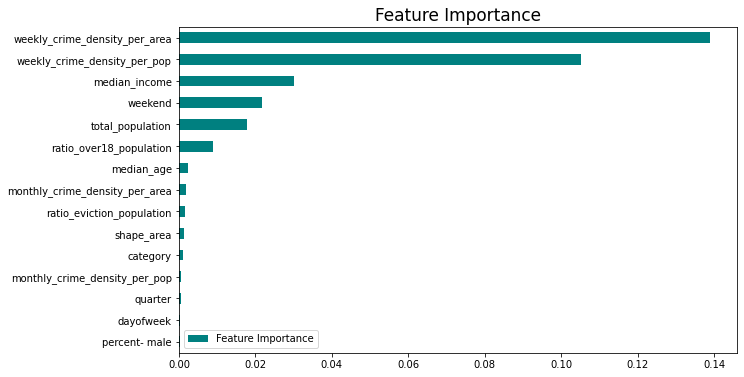

In [479]:
# Feauture importance
final = {} 
for a, b in zip(X_train.columns, pipe_4.named_steps['rf'].feature_importances_):
    final[a] = b 

df = pd.DataFrame.from_dict(final, orient='index').rename(columns={0: 'Feature Importance'})
fig, ax = plt.subplots(figsize=(10,6))

df.sort_values(by='Feature Importance').plot(kind='barh',color='teal', ax=ax)
ax.set_title('Feature Importance', fontsize=17)
plt.show()

We use violin plots to check the difference between the predict_proba output for the training and test datasets. The below figure confirms that the probability output of test dataset for each crime category matches that of training dataset.

In [480]:
# Distribution of Probabilities
train_prob=pd.DataFrame({'category':X_train['category'], 'probability of incidence': pipe_4.predict_proba(X_train)[:,1] })
train_prob = train_prob.sort_values(by='category')

test_prob=pd.DataFrame({'category':X_test['category'], 'probability of incidence': pipe_4.predict_proba(X_test)[:,1] })
test_prob = test_prob.sort_values(by='category')

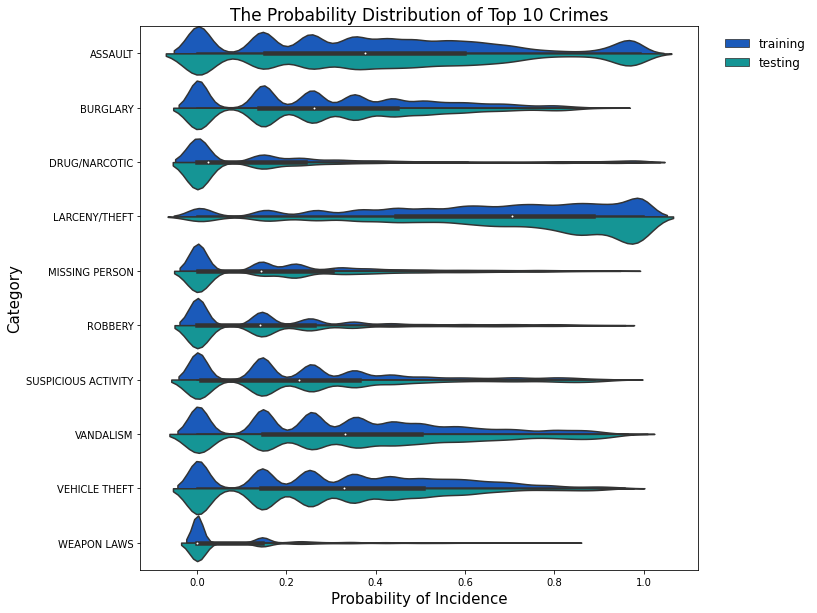

In [481]:
train_prob['type']='training'
test_prob['type']='testing'

plt.figure(figsize=(10,10))
sns.violinplot(y='category', x= 'probability of incidence',
               data=pd.concat([train_prob, test_prob], axis=0), 
               split=True, hue='type', palette='winter', width=1)

plt.ylabel('Category', fontsize=15)
plt.xlabel('Probability of Incidence', fontsize=15)
plt.title('The Probability Distribution of Selected Crimes', fontsize=17)
plt.legend( bbox_to_anchor=(1.2,0.95), borderaxespad=0, loc='right',fontsize=12,title_fontsize=14, frameon=False)
plt.show()

### Fifth Model 

We try to use XGBClassifier to improve the score of our model.

In [89]:
# XGBOOST
ct = ColumnTransformer ([('onehot' , OneHotEncoder(sparse=False),
                      ['category'])]
                      , remainder ='passthrough')

pipe_5 = Pipeline([ ('onehot', ct),
                 ('scaler', StandardScaler()),
                 ('xgb', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)) ])   

pipe_5.fit(X_train,y_train_classification)

Pipeline(memory=None,
         steps=[('onehot',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=False),
                                                  ['category'])],
                                   verbose=Fal

In [90]:
y_prediction_classification_5= pipe_5.predict (X_test)

In [91]:
print(confusion_matrix(y_test_classification,y_prediction_classification_5))
print(classification_report(y_test_classification,y_prediction_classification_5))
print(accuracy_score(y_test_classification,y_prediction_classification_5))

[[278732  24804]
 [ 49701  73427]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88    303536
           1       0.75      0.60      0.66    123128

    accuracy                           0.83    426664
   macro avg       0.80      0.76      0.77    426664
weighted avg       0.82      0.83      0.82    426664

0.8253778148613429


### Sixth Model 

In [96]:
ct = ColumnTransformer ([('onehot' , OneHotEncoder(sparse=False),
                      ['category'])]
                      , remainder ='passthrough')

pipe_6 = Pipeline([ ('onehot', ct),
                 ('scaler', StandardScaler()),
                 ('xgb', xgb.XGBClassifier()) ])




gs_6 = GridSearchCV(pipe_6,  {'xgb__max_depth': [8,10],
                                  'xgb__n_estimators' : [50, 100, 150],
                                  'xgb__learning_rate' : [0.01, 0.05, 0.08,0.1],
                                  'xgb__gamma': [0],
                                  'xgb__colsample_bytree': [0.5,1],
                                  'xgb__gamma': [0],
                                  'xgb__colsample_bytree': [0.7]},
    
                       cv=3, n_jobs=1, verbose=2,
                       refit=False)   


gs_6.fit(X_train, y_train_classification)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=50 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=50, total=  36.9s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.8s remaining:    0.0s


[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=50, total=  40.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=50 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=50, total=  43.4s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=100 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=100, total= 1.4min
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=100 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=100, total= 1.4min
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=100 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, 

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.08, xgb__max_depth=8, xgb__n_estimators=50, total=  34.1s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.08, xgb__max_depth=8, xgb__n_estimators=50 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.08, xgb__max_depth=8, xgb__n_estimators=50, total=  35.3s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.08, xgb__max_depth=8, xgb__n_estimators=50 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.08, xgb__max_depth=8, xgb__n_estimators=50, total=  36.6s
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.08, xgb__max_depth=8, xgb__n_estimators=100 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.08, xgb__max_depth=8, xgb__n_estimators=100, total= 1.2min
[CV] xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.08, xgb__max_depth=8, xgb__n_estimators=100 
[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xg

[CV]  xgb__colsample_bytree=0.7, xgb__gamma=0, xgb__learning_rate=0.1, xgb__max_depth=10, xgb__n_estimators=150, total= 2.3min


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 97.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('onehot',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(categorical_features=None,
                                                                                       categories=None,
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                  

In [98]:
gs_6.best_params_

{'xgb__colsample_bytree': 0.7,
 'xgb__gamma': 0,
 'xgb__learning_rate': 0.08,
 'xgb__max_depth': 8,
 'xgb__n_estimators': 50}

As we set "refit=False", now we need to refit our model on the best parameters.

In [90]:
# Refitting on the best parameters
ct = ColumnTransformer ([('onehot' , OneHotEncoder(sparse=False),
                      ['category'])]
                      , remainder ='passthrough')

pipe_6 = Pipeline([ ('onehot', ct),
                 ('scaler', StandardScaler()),
                 ('xgb', xgb.XGBClassifier(n_estimators= 50,
                                          max_depth= 8,
                                          earning_rate= 0.08,
                                           gamma= 0,
                                           colsample_bytree= 0.7)) ])


pipe_6.fit(X_train, y_train_classification)

[20:35:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { earning_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(memory=None,
         steps=[('onehot',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=False),
                                                  ['category'])],
                                   verbose=Fal

In [92]:
y_prediction_classification_6= pipe_6.predict (X_test)

In [93]:
print(confusion_matrix(y_test_classification,y_prediction_classification_6))
print(classification_report(y_test_classification,y_prediction_classification_6))
print(accuracy_score(y_test_classification,y_prediction_classification_6))

[[278551  24985]
 [ 49716  73412]]
              precision    recall  f1-score   support

           0       0.85      0.92      0.88    303536
           1       0.75      0.60      0.66    123128

    accuracy                           0.82    426664
   macro avg       0.80      0.76      0.77    426664
weighted avg       0.82      0.82      0.82    426664

0.8249184369902312


The score of this model is not higher than previous models. So far, the Fourth Model (pipe_4) has the highest accuracy score and we use it for probability prediction.

# Prediction of Crime Incidence 

We want to predict the probability of different categories of crimes at a given neighborhood and date by our best performing model (pipe_4). Therefore, we create a function that takes date, name of neighborhood and name of the predictive model, and gives us the probability of different categories of crimes. 

In [447]:
# Predicting probability of different categories of crimes at a given neighborhood & date, by the best performing model.
def probability(x,y, model):
    
    unique_date = gdf_crime_number['date'].apply(lambda x: datetime.strftime(x, "%Y-%m-%d")).unique()
    unique_neighborhood = gdf_crime_number['neighborhood'].unique()
    
    if (x in unique_date) and (y in unique_neighborhood):
        
        filtered= gdf_crime_number[(gdf_crime_number['date']==x) & (gdf_crime_number['neighborhood']==y) ]
        
        filtered = filtered.drop(['date', 'neighborhood', 'crime_number', 'geometry','total- over 18',
                         'year', 'num_evictions', 'season','female_population','male_population'], axis=1)
        
        df_plot=pd.DataFrame({'category':filtered['category'], 
                         'probability of incidence': model.predict_proba(filtered)[:,1] }).sort_values(by='probability of incidence', 
                          ascending=False).reset_index(drop=True)
          
        labels = df_plot['category']
        data = df_plot['probability of incidence']
        #number of data points
        n = len(data)
        #find max value for full ring
        k = 10 ** int(log10(max(data)))
        m = k * (1 + max(data) // k)
      
        #radius of donut chart
        r = 1
        #calculate width of each ring
        w = r / n      
        #create colors along a chosen colormap
        colors = [cm.rainbow(i / n) for i in range(n)]    
        #create figure, axis   
        fig, ax = plt.subplots(figsize=(8,8))
        ax.axis("equal")
        percent=df_plot['probability of incidence'].apply(lambda x: round(100*x,2))
        #create rings of donut chart
        for i in range(n):
            #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
            innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90,
                                  labels = ["", f'{labels[i]} : {percent[i]}%'], labeldistance = 1 - 1 / (1.5 * (n - i)),
                                  textprops = {"alpha": 0}, colors = ["white", colors[i]])
            plt.setp(innerring, width = w, edgecolor = "white")
        plt.title(f'\nProbabilities of Crimes on {x} in {y}',loc='center', fontsize=18)
        plt.legend( bbox_to_anchor=(1.45,0.69), borderaxespad=0, loc='right',fontsize=12,title_fontsize=14, frameon=False)
        plt.show()



    elif (x not in unique_date) and (y in unique_neighborhood):
        
        filtered= gdf_crime_number[gdf_crime_number['neighborhood']==y]
        
        #date extraction                   
        timestamp = pd.to_datetime(x)
        date = {}
        date['dayofweek'] = timestamp.dayofweek
        date['weekend'] = [1 if timestamp.dayofweek in [5,6] else 0][0]
        date['quarter'] = timestamp.quarter
        date = pd.DataFrame(data=date, index=[0])
        
        #area extraction  
        area = filtered.drop_duplicates('neighborhood')[['shape_area','total_population','median_age', 'median_income',
                                                              'percent- male', 'ratio_over18_population']]
        
        # eviction extraction
        evictions_median = filtered.drop_duplicates(['neighborhood','year']).median()['ratio_eviction_population']
        evictions= pd.DataFrame(data=evictions_median, index=[0], columns={'ratio_eviction_population'})
        
        # category extraction
        category = filtered.drop_duplicates('category')['category']
        
        #weekly, monthly extraction
        weekly_monthly = filtered.drop_duplicates(['date','neighborhood',
                                           'category']).groupby(['neighborhood',
                                                                 'category']).median()[['monthly_crime_density_per_pop',
                                                                                        'monthly_crime_density_per_area', 
                                                                                        'weekly_crime_density_per_pop',
                                                                                        'weekly_crime_density_per_area']]
        
        weekly_monthly = weekly_monthly.reset_index().drop('neighborhood', axis=1)
        
        #concatenation, merging
        df = pd.concat([area.reset_index(drop=True).copy(),
           evictions.reset_index(drop=True).copy(),
           date.reset_index(drop=True).copy()] , axis=1)
        df= pd.concat([category.reset_index(drop=True).copy(),df], axis=1).fillna(method='ffill')
        df= df.merge(weekly_monthly, on='category')
        df= df.reindex(sorted(df.columns), axis=1)
        
        df_plot=pd.DataFrame({'category':df['category'], 
                         'probability of incidence': model.predict_proba(df)[:,1] }).sort_values(by='probability of incidence', 
                          ascending=False).reset_index(drop=True)
        
        labels = df_plot['category']
        data = df_plot['probability of incidence']
        #number of data points
        n = len(data)
        #find max value for full ring
        k = 10 ** int(log10(max(data)))
        m = k * (1 + max(data) // k)      
        #radius of donut chart
        r = 1
        #calculate width of each ring
        w = r / n        
        #create colors along a chosen colormap
        colors = [cm.rainbow(i / n) for i in range(n)]        
        #create figure, axis       
        fig, ax = plt.subplots(figsize=(8,8))
        ax.axis("equal") 
        percent=df_plot['probability of incidence'].apply(lambda x: round(100*x,2))
        #create rings of donut chart
        for i in range(n):
            #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
            innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90,
                                  labels = ["", f'{labels[i]} : {percent[i]}%'], labeldistance = 1 - 1 / (1.5 * (n - i)),
                                  textprops = {"alpha": 0}, colors = ["white", colors[i]])
            plt.setp(innerring, width = w, edgecolor = "white")
        plt.title(f'\nProbabilities of Crimes on {x} in {y}',loc='center', fontsize=18)
        plt.legend( bbox_to_anchor=(1.45,0.69), borderaxespad=0, loc='right',fontsize=12,title_fontsize=14, frameon=False)
        plt.show()
        
    
    else:
        print('\033[1m' +'\033[7m'+'\033[91m'+ 'Error: Check the Spelling of the Neighborhood')

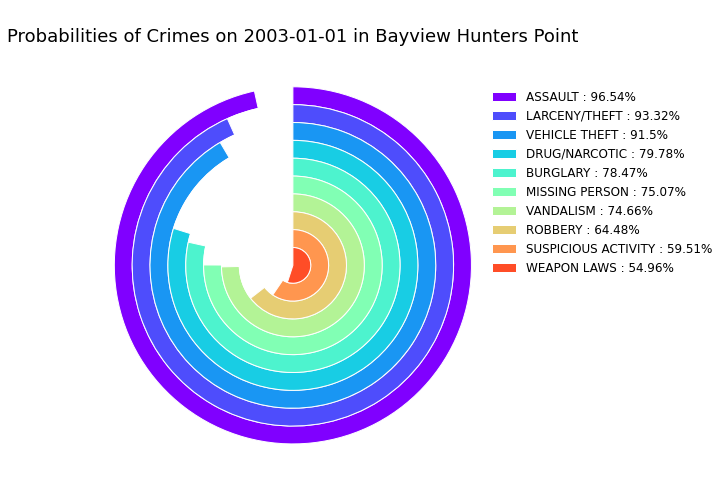

In [448]:
# Example, In the Past
probability( '2003-01-01', 'Bayview Hunters Point', model=pipe_4)

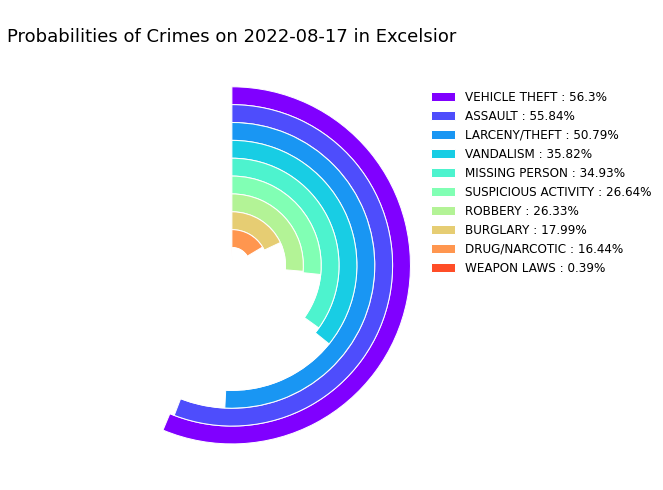

In [449]:
# Example, In the Future
probability( '2022-08-17', 'Excelsior', model=pipe_4)

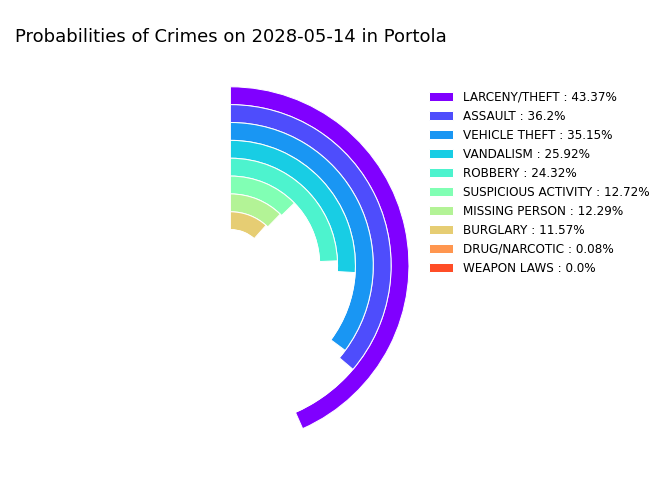

In [450]:
# Example, In the Future
probability( '2028-05-14', 'Portola', model=pipe_4)

In [451]:
# Example, Incorrect Neighborhood
probability( '2003-01-01', 'Bellevue', model=pipe_4)

Error: Check the Spelling of the Neighborhood
